# Data Exploration & Visualisation

# Contents
[Univariate Analysis](#Univariate-Analysis)<br>
[Bivariate Analysis (Predictor vs Label)](#Bivariate-Analysis-(Predictor-vs-Label))<br>
[Bivariate Analysis (Predictor vs Predictor)](#Bivariate-Analysis-(Predictor-vs-Predictor))<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as ss
%matplotlib inline

In [2]:
#Combining both files -> get all data in one file
feature = pd.read_csv('data/train_values.csv')
label = pd.read_csv('data/train_labels.csv')

data = feature.join(label.set_index('building_id'), on='building_id')
data.drop(columns=['building_id'], inplace=True)

In [3]:
#group features with similiar characteristics into one list
num_col = ["count_floors_pre_eq", "age", "area_percentage", "height_percentage", "count_families"]
cat_col = (["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type",
             "position", "plan_configuration", "legal_ownership_status", 'damage_grade'] +
            [ col for col in data.columns if col.startswith("has") ])
has = [ col for col in data.columns if col.startswith("has") ]
damage_label = "damage_grade"
geo = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [4]:
for col in cat_col:
    data[col] = data[col].astype("category")

# Univariate Analysis
[Back to top](#Contents)<br>

<h4>Distributions of damage grade</h4>

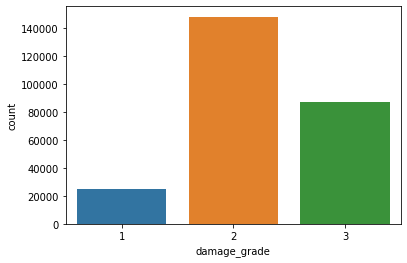

In [5]:
sb.countplot(x='damage_grade', data=data)

<p>damage_grade was unevenly distributed, with the majority belonging to grade 2, and the minority belonging to grade 1. The uneven distribution of damage grade may be a problem during machine learning later on, as models may not be able to predict the minority classes accurately </p>

<h4>Distributions of buildings in different geographical regions</h4>

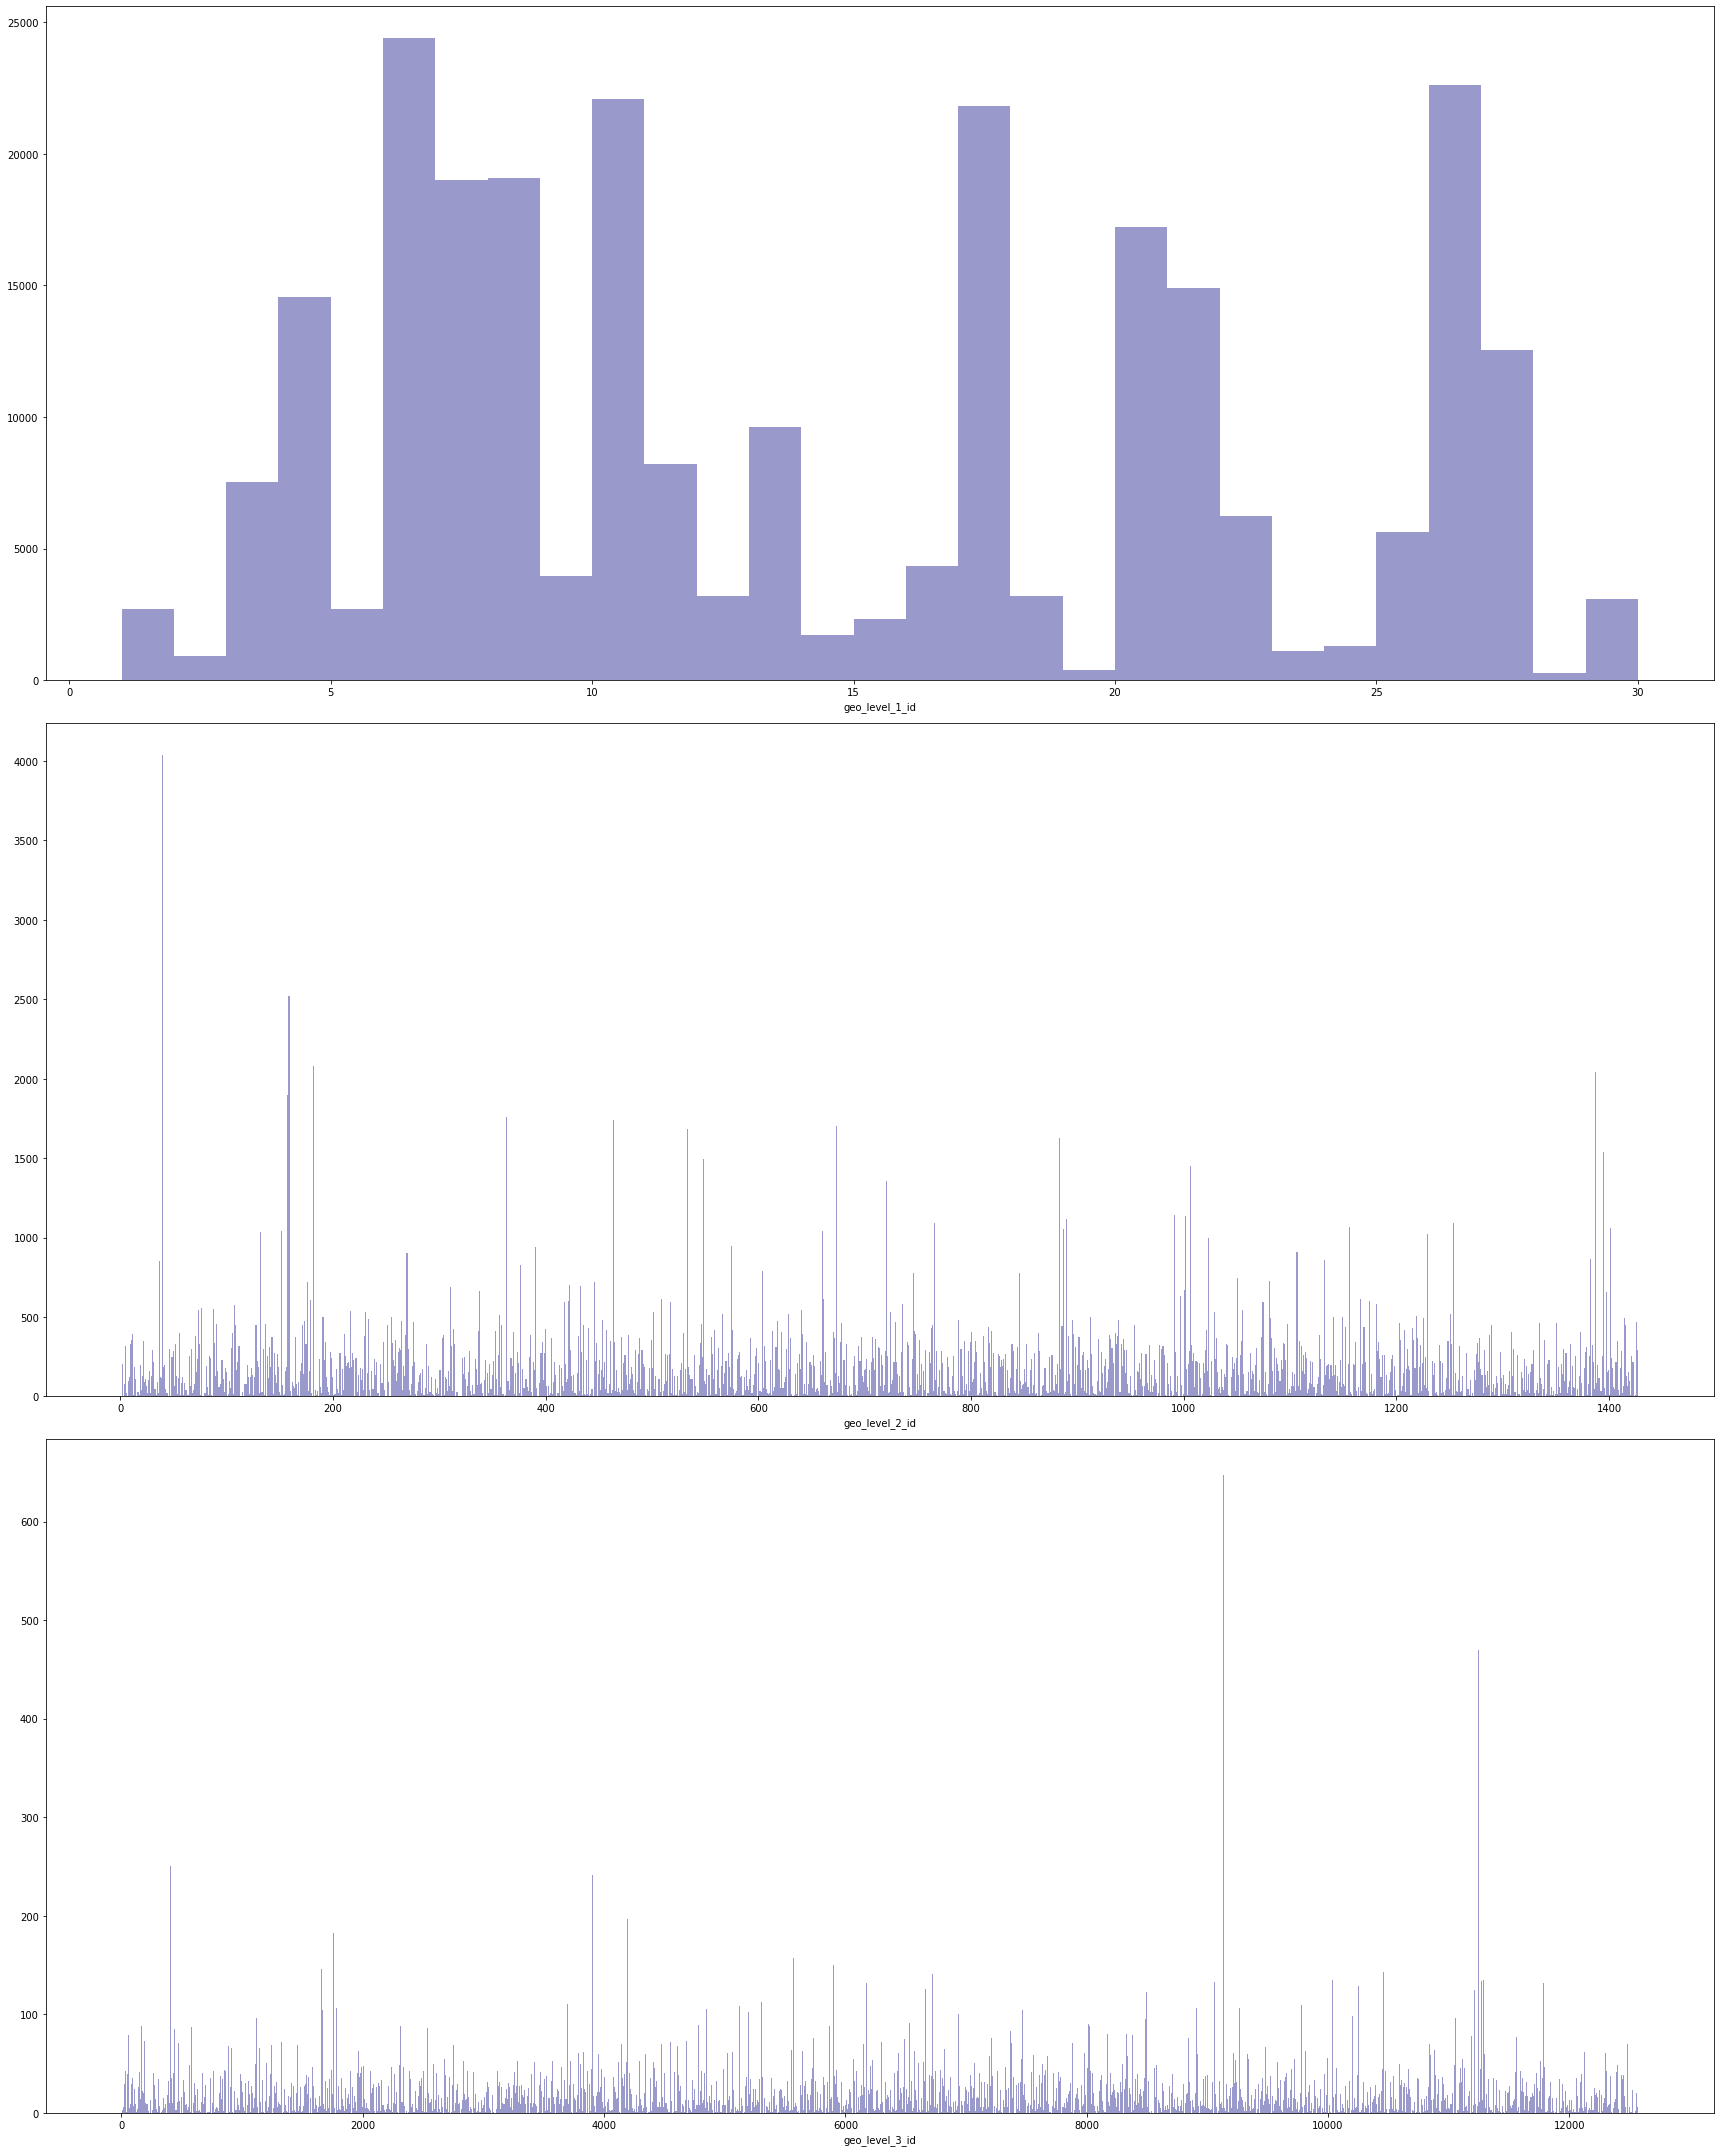

In [6]:
#Distributions of buildings in geo_level_n
f, axes = plt.subplots(len(geo), 1, figsize=(24, 30))
i = 0
for col in geo:
    sb.distplot(data[col], bins=np.arange(1,data[col].max()+1), kde=False, ax=axes[i], color = "navy")
    plt.tight_layout()
    i+=1

<p>From the distribution plots, we can see the distribution of the damaged buildings in the overall region. </p>

<p>We can see some peaks, which could be due to denser population.</p>

<h4>Age</h4>

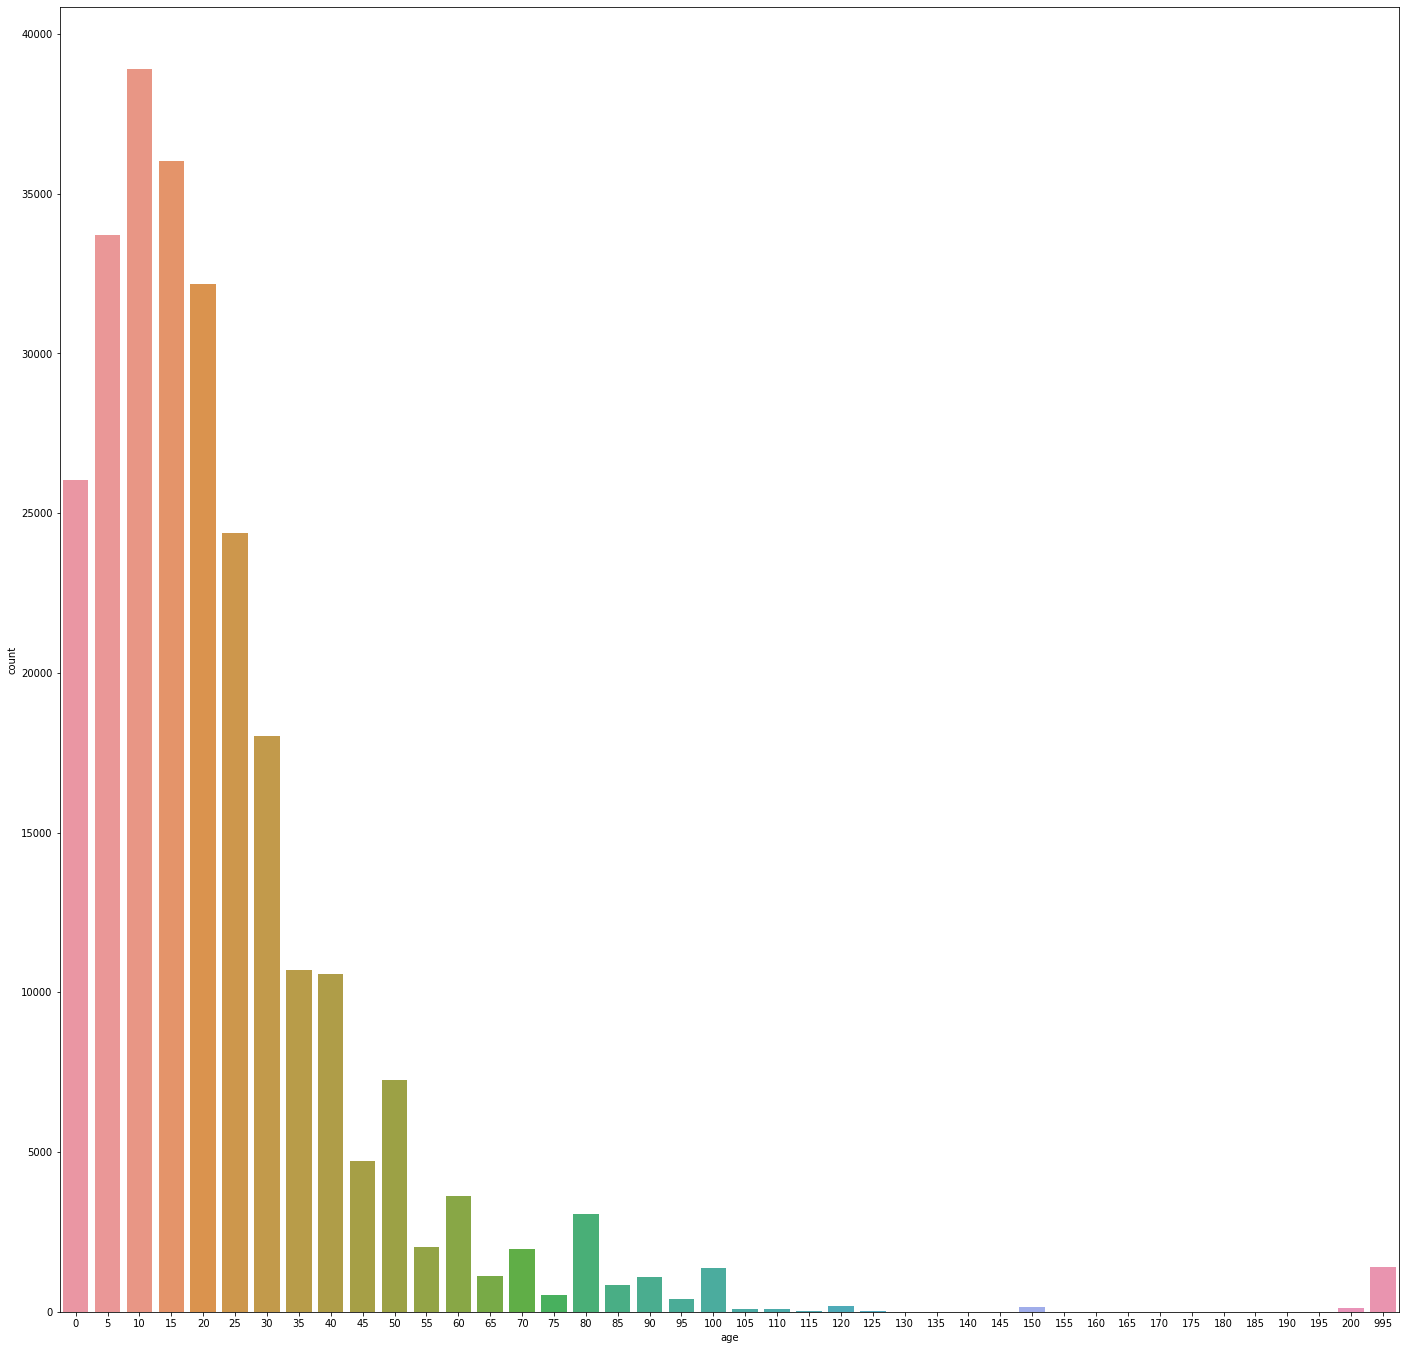

In [7]:
f,axes=plt.subplots(1,1,figsize=(24,24))
sb.countplot(x='age', data=data, orient='h')

<p>Most of the buildings are between 0-35 years old. There are outliers at 995 yrs old, and a few spread beyond 100 yrs old. To get a more accurate representation, we remove these outliers. </p>

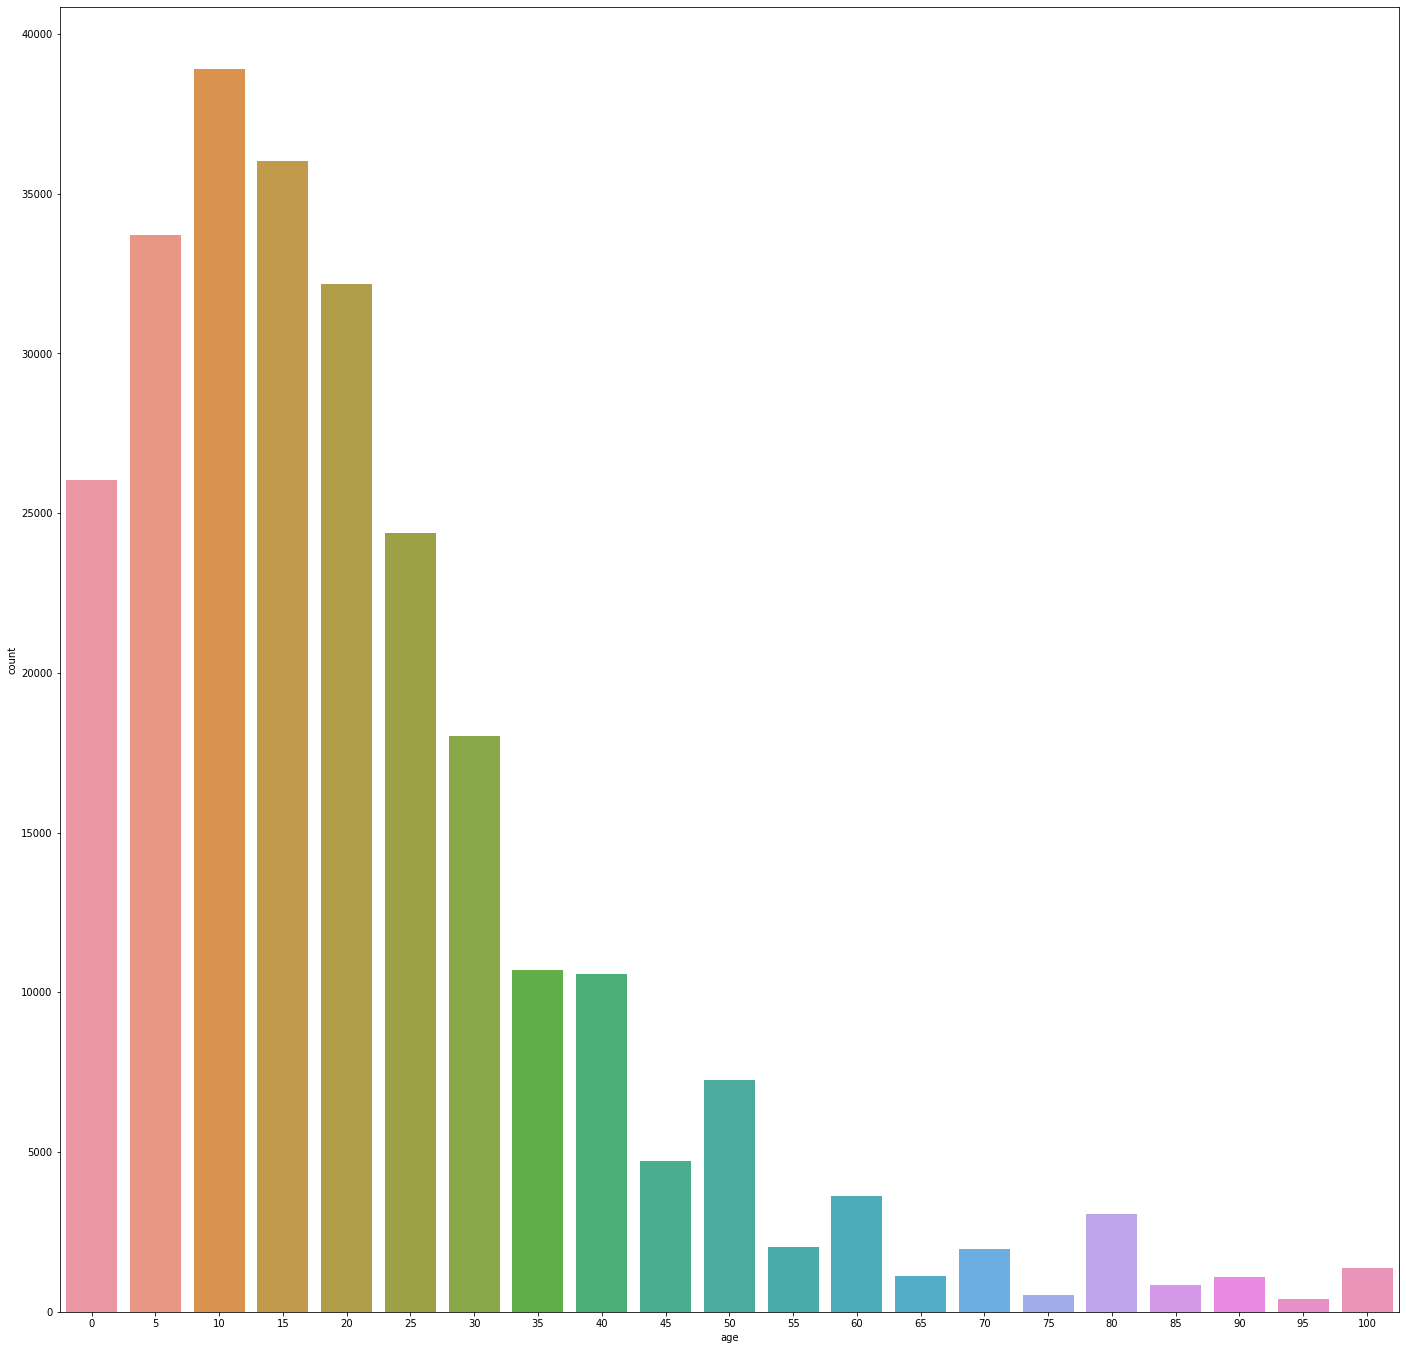

In [8]:
f,axes=plt.subplots(1,1,figsize=(24,24))
sb.countplot(x='age', data=data[data['age'] <= 100], orient='h')

<h4>Area and Height Percentage</h4>

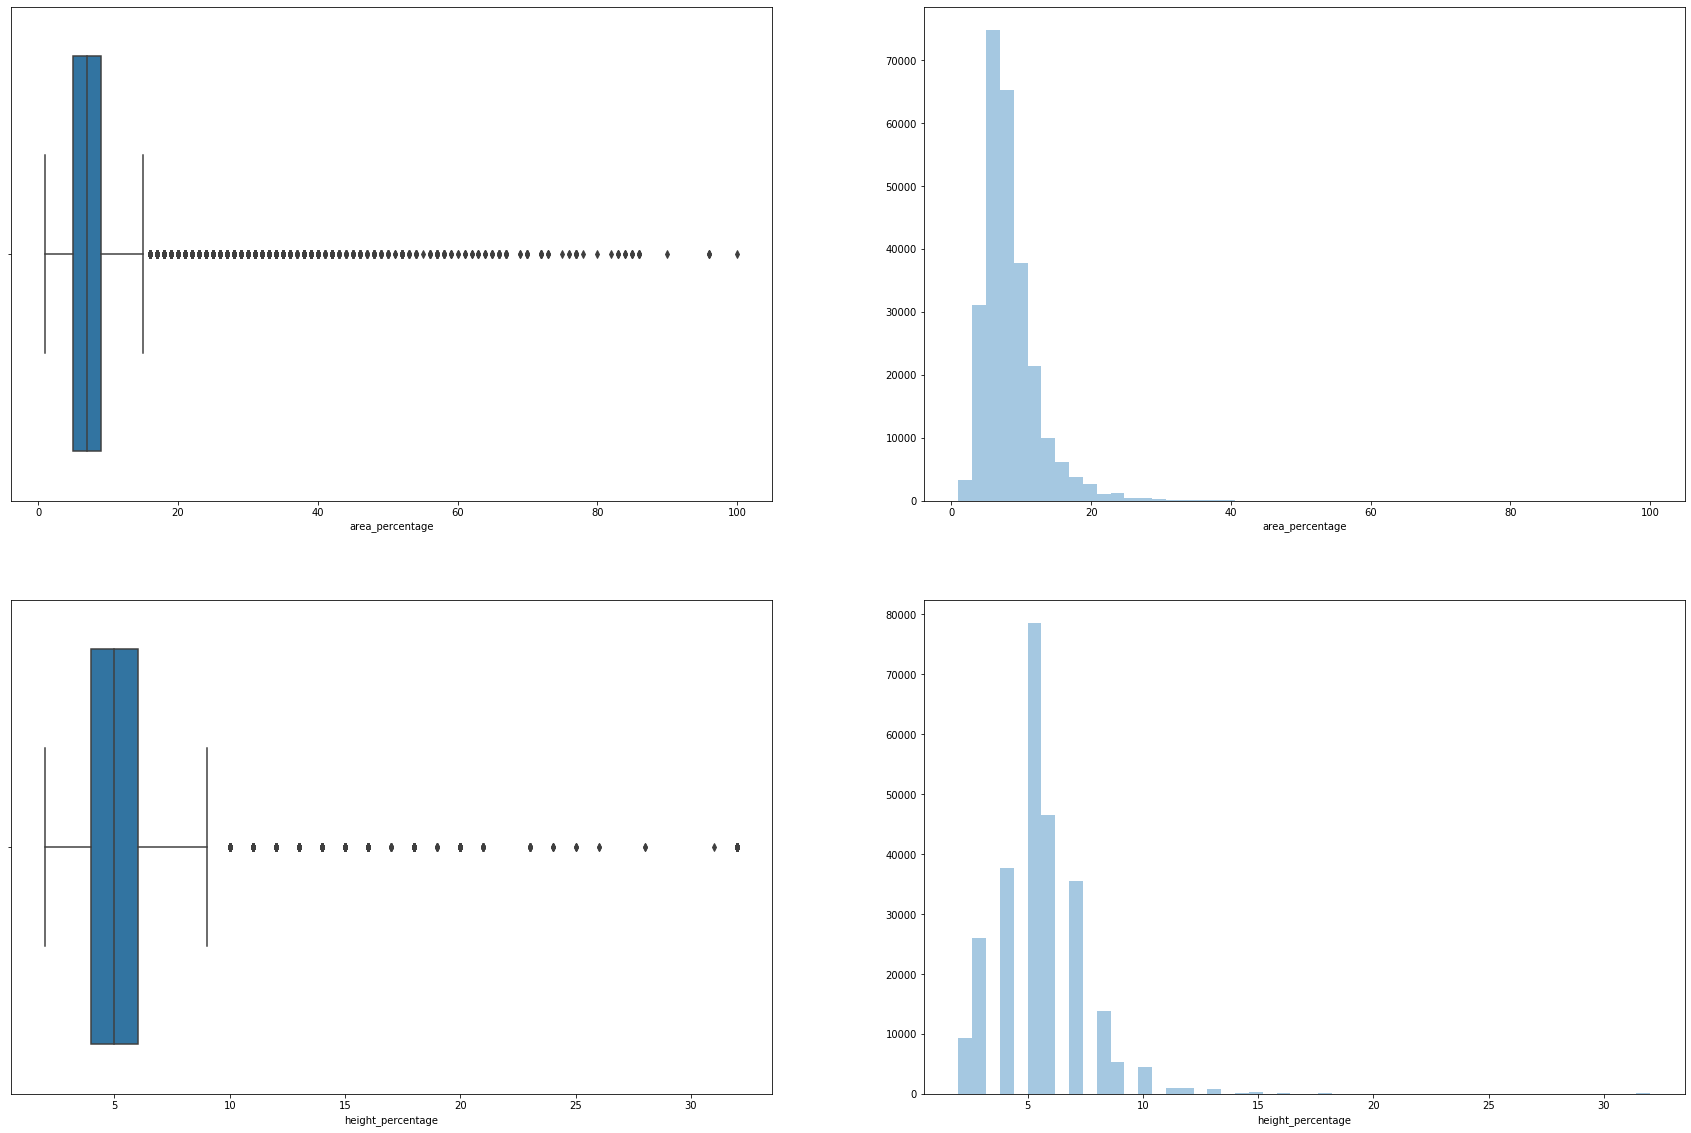

In [9]:
percent = ['area_percentage', 'height_percentage']
f, axes = plt.subplots(len(percent), 2, figsize=(30, 20))
i = 0
for col in percent:
    sb.boxplot(x=col, data=data, orient="h", ax=axes[i][0])
    sb.distplot(data[col], kde=False, ax=axes[i][1])
    i+=1

<p>From the boxplot, we can see that there are a lot of outliers. Most buildings have low area and height percentage </p>

<p>Here we remove the outliers and replot the data distribution. They seem to follow approximately a Normal distribution.</p>

In [10]:
def plot_ex_out(data, var):
    q1 = data[var].quantile(0.25)
    q3 = data[var].quantile(0.75)
    print("Outliers: ", np.sum(data[data[var] >= (q3+1.5*(q3-q1))][var].value_counts()))
    print("Total: ", np.sum(data[var].value_counts()))
    f, axes = plt.subplots(1, 2, figsize=(24, 10))
    sb.boxplot(x=var, data=data[data[var]<= (q3+1.5*(q3-q1))] , orient="h", ax=axes[0])
    sb.distplot(data[data[var]<= (q3+1.5*(q3-q1))][var], kde=False, ax=axes[1])

Outliers:  17046
Total:  260601


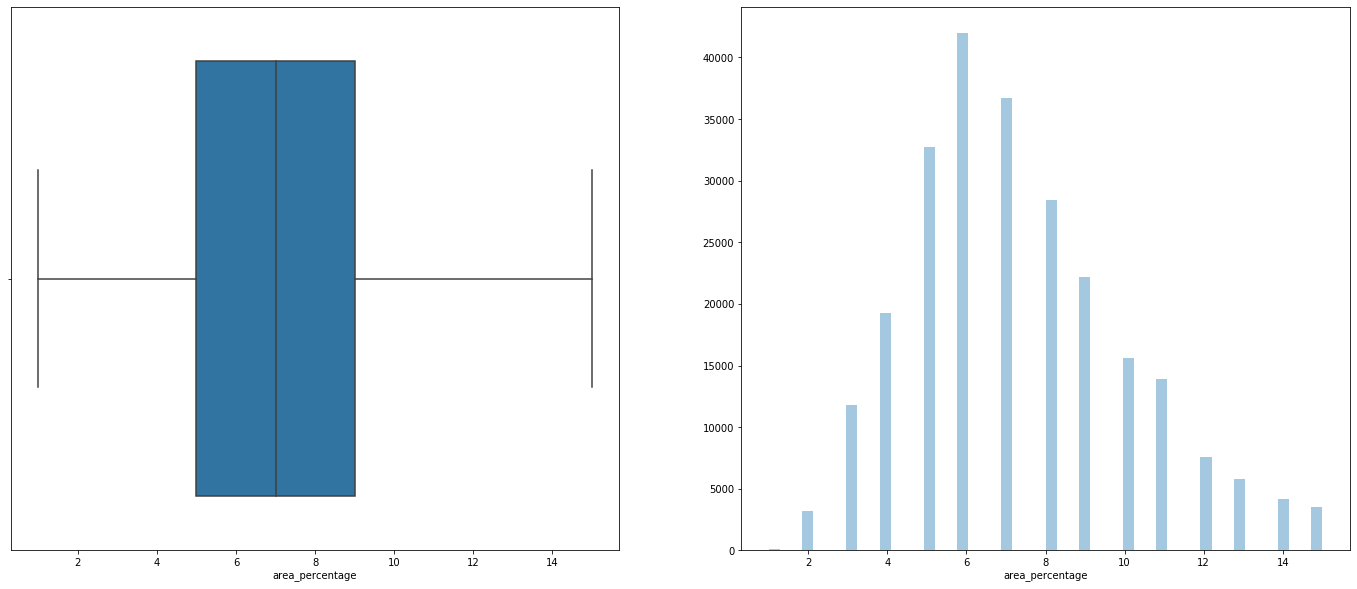

In [11]:
plot_ex_out(data, 'area_percentage')

Outliers:  13219
Total:  260601


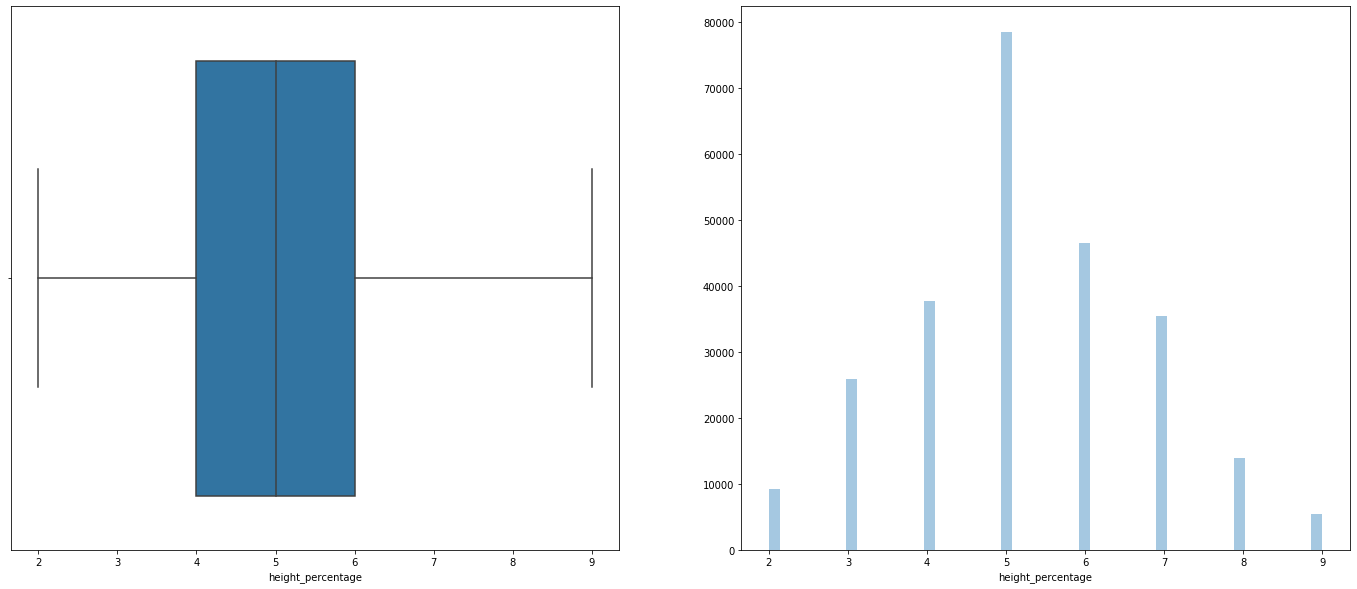

In [12]:
plot_ex_out(data, 'height_percentage')

<h4>Distribution of no. of floors per building before earthquake</h4>

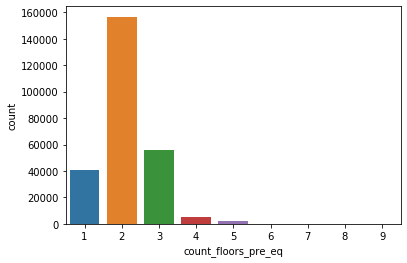

In [13]:
sb.countplot(data["count_floors_pre_eq"]) 

<p>There seems to be only a few high-rise buildings. Most of the buildings are 1-3 storeys high.</p>

<h4>Distribution of number of families that live in the building before earthquake</h4>

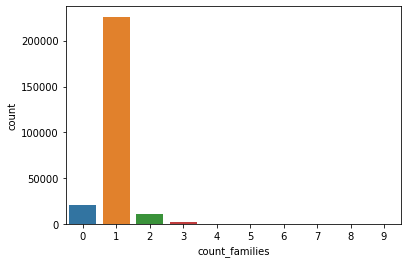

In [14]:
sb.countplot(data["count_families"]) 

<p>Most buildings house only 1 family.</p> 

<h4>Distributions of the categorical features</h4>

In [15]:
def plot_uni_cat(data, cat_col):
    n = len(cat_col)
    f, axes = plt.subplots(n, 1, figsize=(24, 15*n))
    i = 0
    if n == 1:
        sb.countplot(x=cat_col[i], data=data, orient='h', ax=axes)
        return
    for i in range(n):
        sb.countplot(x=cat_col[i], data=data, orient='h', ax=axes[i])
        plt.tight_layout()

In [16]:
plot_uni_cat(data, cat_col)

# Bivariate Analysis (Predictor vs Label)
[Back to top](#Contents)<br>

In [17]:
def count_2vars(cols, data):
    grouped = data.groupby([cols[0]])[cols[1]]
    result = (grouped.value_counts()
                     .rename("count")
                     .reset_index()
                     .sort_values(cols[0]))
    freq = (grouped.value_counts(normalize=True)
                     .rename("frequency")
                     .reset_index()
                     .sort_values(cols[0]))
    result["frequency"] = freq["frequency"]
    return result

def plotfreq(data, col, axes):
    count_data = count_2vars([col, damage_label], data)
    sb.barplot(x=col, y="frequency", hue=damage_label, data=count_data, ax = axes)
    for index, row in count_data.iterrows():
        axes.text(row[col]+0.27*(row[damage_label]-2), row["frequency"],
                        round(row["frequency"],3), color='black', ha="center")

#### Numeric predictors vs damage grade

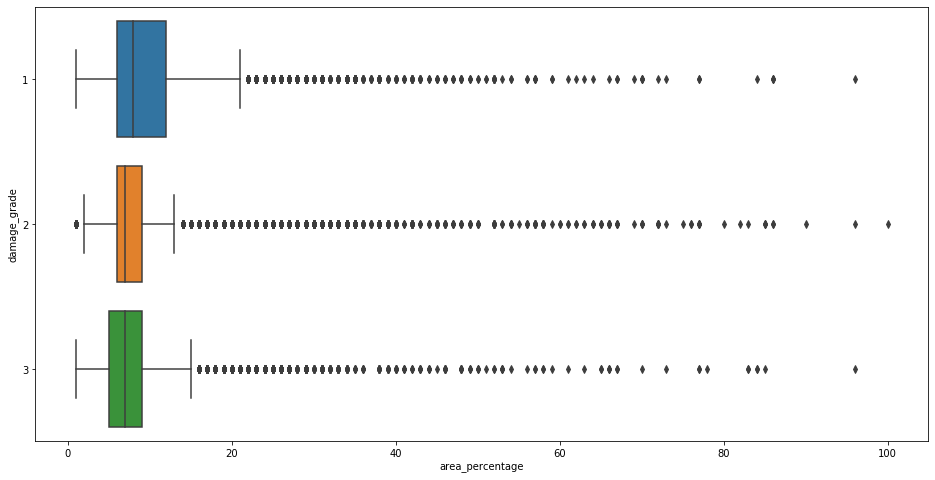

In [18]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.boxplot(x = 'area_percentage', y = 'damage_grade', data = data, ax = axes)

From the boxplot, we can see that there are a lot of outliers.

Here, we remove the outliers and re-plot the boxplot for a clearer representation of the majority distribution

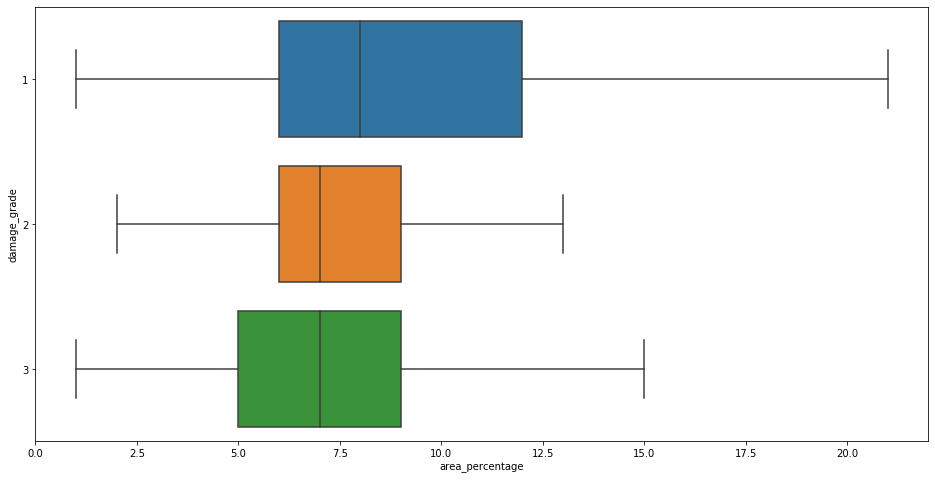

In [19]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.boxplot(x = 'area_percentage', y = 'damage_grade', data = data, ax = axes, showfliers = False)

The boxplot showed that the larger the normalized area of the building footprint, the more likely it is for the buildings to receive less damage. 

However, the relationship between damage grade and area percentage is not very strong, because the distribution of area_percentage for each damage grade is not very different from one another.

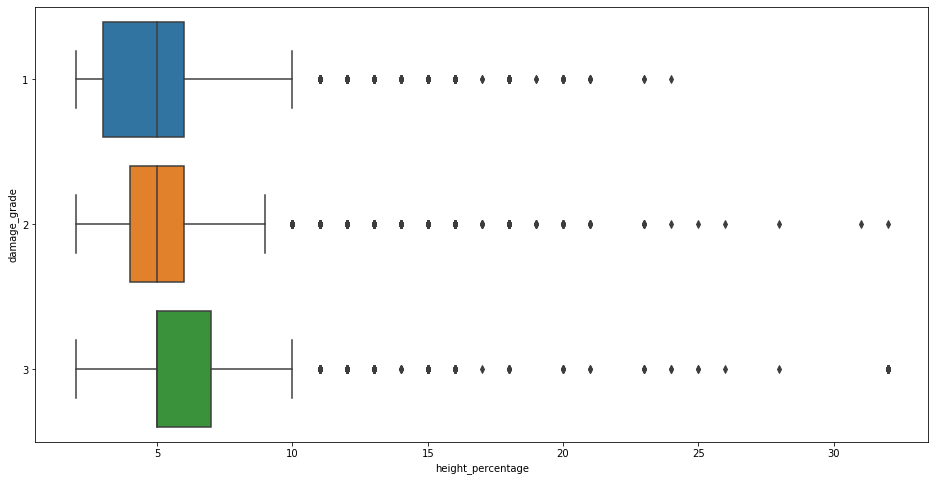

In [20]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.boxplot(x = 'height_percentage', y = 'damage_grade', data = data, ax = axes)

From the boxplot, we can see that there are some outliers.

Here, we remove the outliers and re-plot the boxplot for a clearer representation of the majority distribution

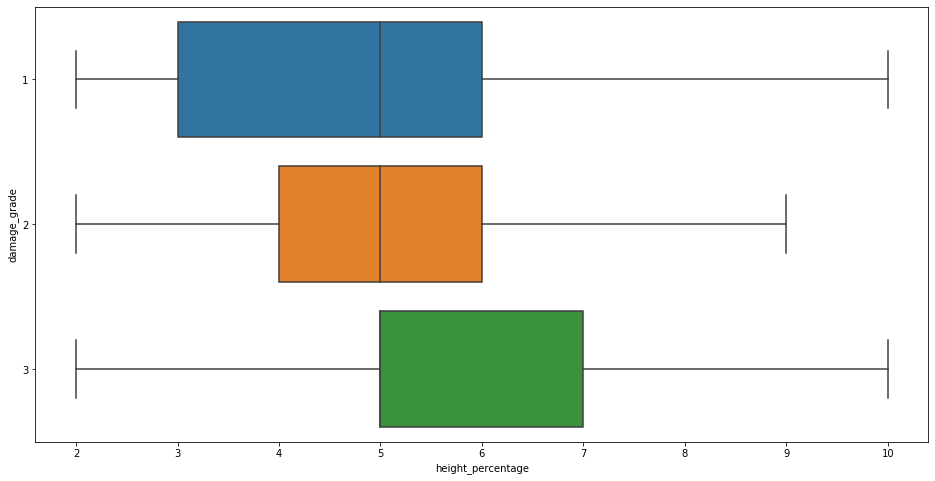

In [21]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.boxplot(x = 'height_percentage', y = 'damage_grade', data = data, ax = axes, showfliers = False)

The boxplot shows the higher the normalized height of the building footprint, the more likely it is for the building to receive more damage.

However, the relationship between damage grade and height percentage is not very strong as well, because the distribution of height_percentage for each damage grade is not very different from one another.

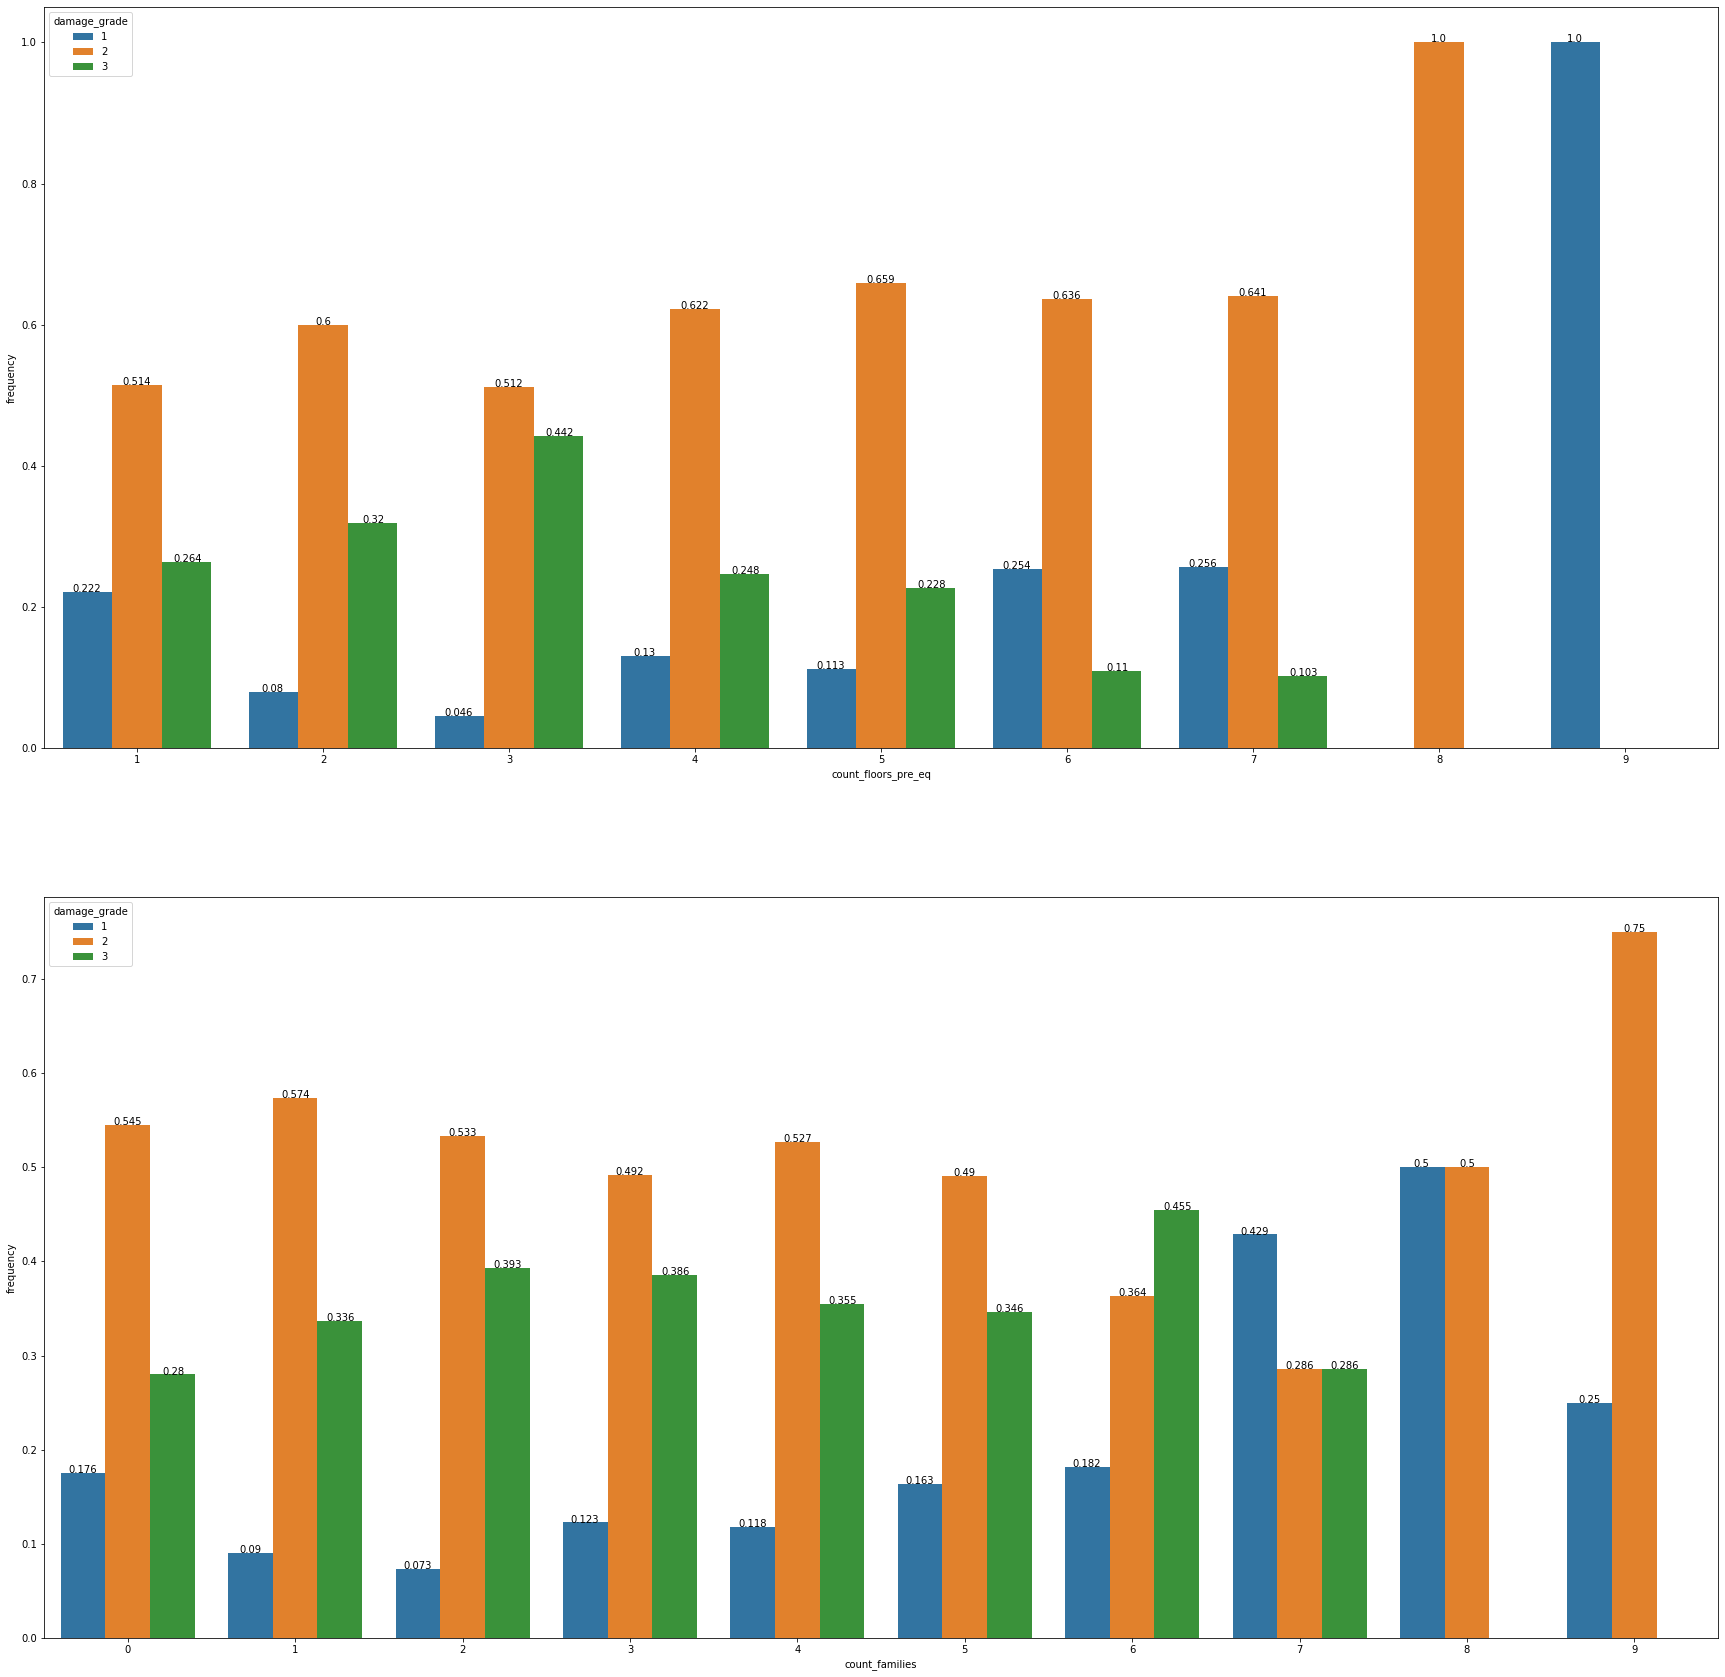

In [22]:
def plotfreq_count_floors_pre_eq(data, col, axes):
    count_data = count_2vars([col, damage_label], data)
    sb.barplot(x=col, y="frequency", hue=damage_label, data=count_data, ax = axes)
    for index, row in count_data.iterrows():
        axes.text(row[col]+0.27*(row[damage_label]-2)-1, row["frequency"],
                        round(row["frequency"],3), color='black', ha="center")

l = ['count_floors_pre_eq','count_families']
f,axes = plt.subplots(2,1,figsize=(30,30))
for i in range(2):
    j=i
    if l[j]== 'count_floors_pre_eq':
        plotfreq_count_floors_pre_eq(data, l[j], axes[i])
    else:
        plotfreq(data, l[j], axes[i])

#### count_floor_pre_eq

From univariate analysis, we already know that there is extremely low number of buildings with count_floor_pre_eq > 5. Therefore we will only compare buildings with count_floor_pre_eq <= 5. 

We cannot conclude any obvious pattern from the bar plot. We initially believed that if a building has higher floor numbers, it will take more damage. However from the barplot, buildings with 3 floors suffered the most damage. As the floor number increased to 4 and 5, the damage taken by buildings actually decreased, which contradicted with our expectation.

#### count_families

From univariate analysis, we already know that there are extremely low number of buildings with count_families > 3. Therefore we will only compare buildings with count_familes <= 3. 

We observed as the number of families that live in the building increases, the ratio of damage_grade = 3 against damage_grade_2 increases

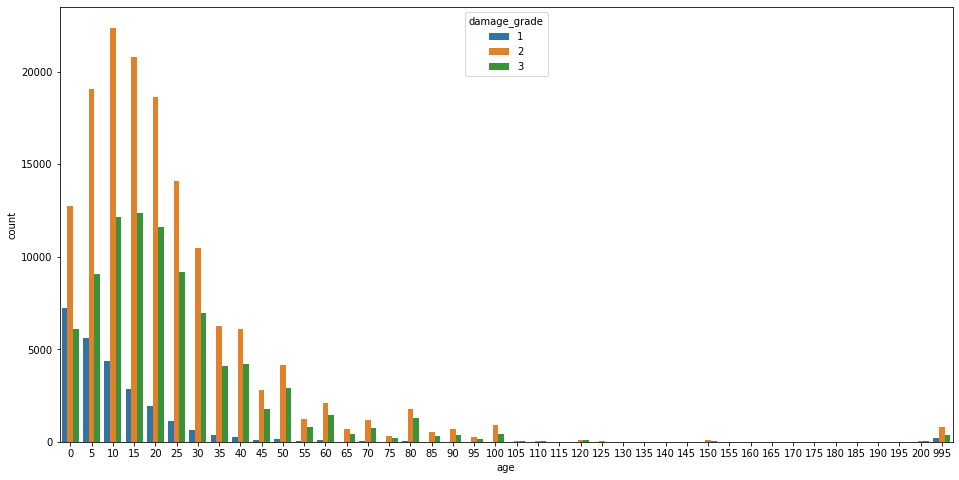

In [23]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.countplot(x = 'age', hue='damage_grade', data=data, ax=axes)

From the hist-plot, we can see that there are very few buildings older than 100 years old.

Here, we remove buildings that are older than 100 years old and replot the graph for a clearer representation of the majority class

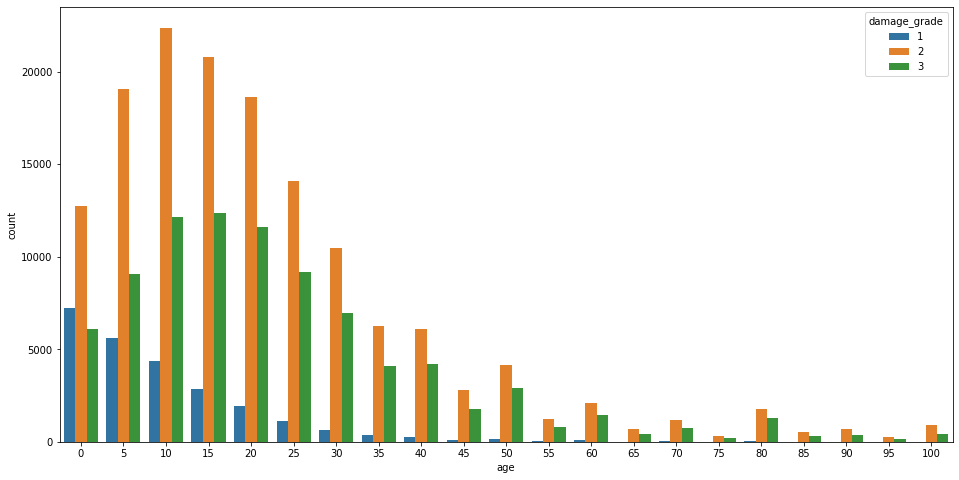

In [24]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
sb.countplot(x = 'age', hue='damage_grade', data=data[data['age'] <= 100], ax=axes)

From the figure, we can conclude that older buildings are more likely to take serious damage

<h4>Geo_Level 1 vs Damage Grade</h4>

In [25]:
x = data['geo_level_1_id'].value_counts()
x = x.sort_index()

index = np.array(x.index)
count = np.array(x)
total_list = list(zip(index, count))
print("Area   Lowdmg        Srsdmg   |   Grade 1      Grade 2      Grade 3   |   Total")
print("**********************************************************************************")

for i in total_list:
    x = i[0]
    y = i[1]
    grade_one = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 1))
    grade_two = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 2))
    grade_three = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 3))
    srs_dmg = grade_two + grade_three
    print("%2d   %4d (%.2f) %5d (%.2f) | %4d (%.2f) %5d (%.2f) %5d (%.2f) |   %5d" %(x, grade_one, grade_one/y, srs_dmg, srs_dmg/y, \
                                                                          grade_one, grade_one/y, grade_two, grade_two/y,\
                                                                          grade_three, grade_three/y, y))


Area   Lowdmg        Srsdmg   |   Grade 1      Grade 2      Grade 3   |   Total
**********************************************************************************
 0    337 (0.08)  3674 (0.92) |  337 (0.08)  3075 (0.77)   599 (0.15) |    4011
 1    411 (0.15)  2290 (0.85) |  411 (0.15)  1985 (0.73)   305 (0.11) |    2701
 2     85 (0.09)   846 (0.91) |   85 (0.09)   610 (0.66)   236 (0.25) |     931
 3    245 (0.03)  7295 (0.97) |  245 (0.03)  4550 (0.60)  2745 (0.36) |    7540
 4    521 (0.04) 14047 (0.96) |  521 (0.04) 11164 (0.77)  2883 (0.20) |   14568
 5    446 (0.17)  2244 (0.83) |  446 (0.17)  2014 (0.75)   230 (0.09) |    2690
 6   2108 (0.09) 22273 (0.91) | 2108 (0.09) 16222 (0.67)  6051 (0.25) |   24381
 7   1033 (0.05) 17961 (0.95) | 1033 (0.05) 11273 (0.59)  6688 (0.35) |   18994
 8    654 (0.03) 18426 (0.97) |  654 (0.03)  8513 (0.45)  9913 (0.52) |   19080
 9    561 (0.14)  3397 (0.86) |  561 (0.14)  2733 (0.69)   664 (0.17) |    3958
10   1211 (0.05) 20868 (0.95) | 1211 

We can conclude from the table above that across nearly all locations, most buildings(>80%) suffered serious damage(damage grade>=2)

However, an exception is found at geo_index_1 = 26, with a significantly higher Lowdmg to Srsdmg ratio. Also, the number of buildings at this location is the second largest across all locations. This may suggest that geo_index_1 = 26 is far from the epicenters.

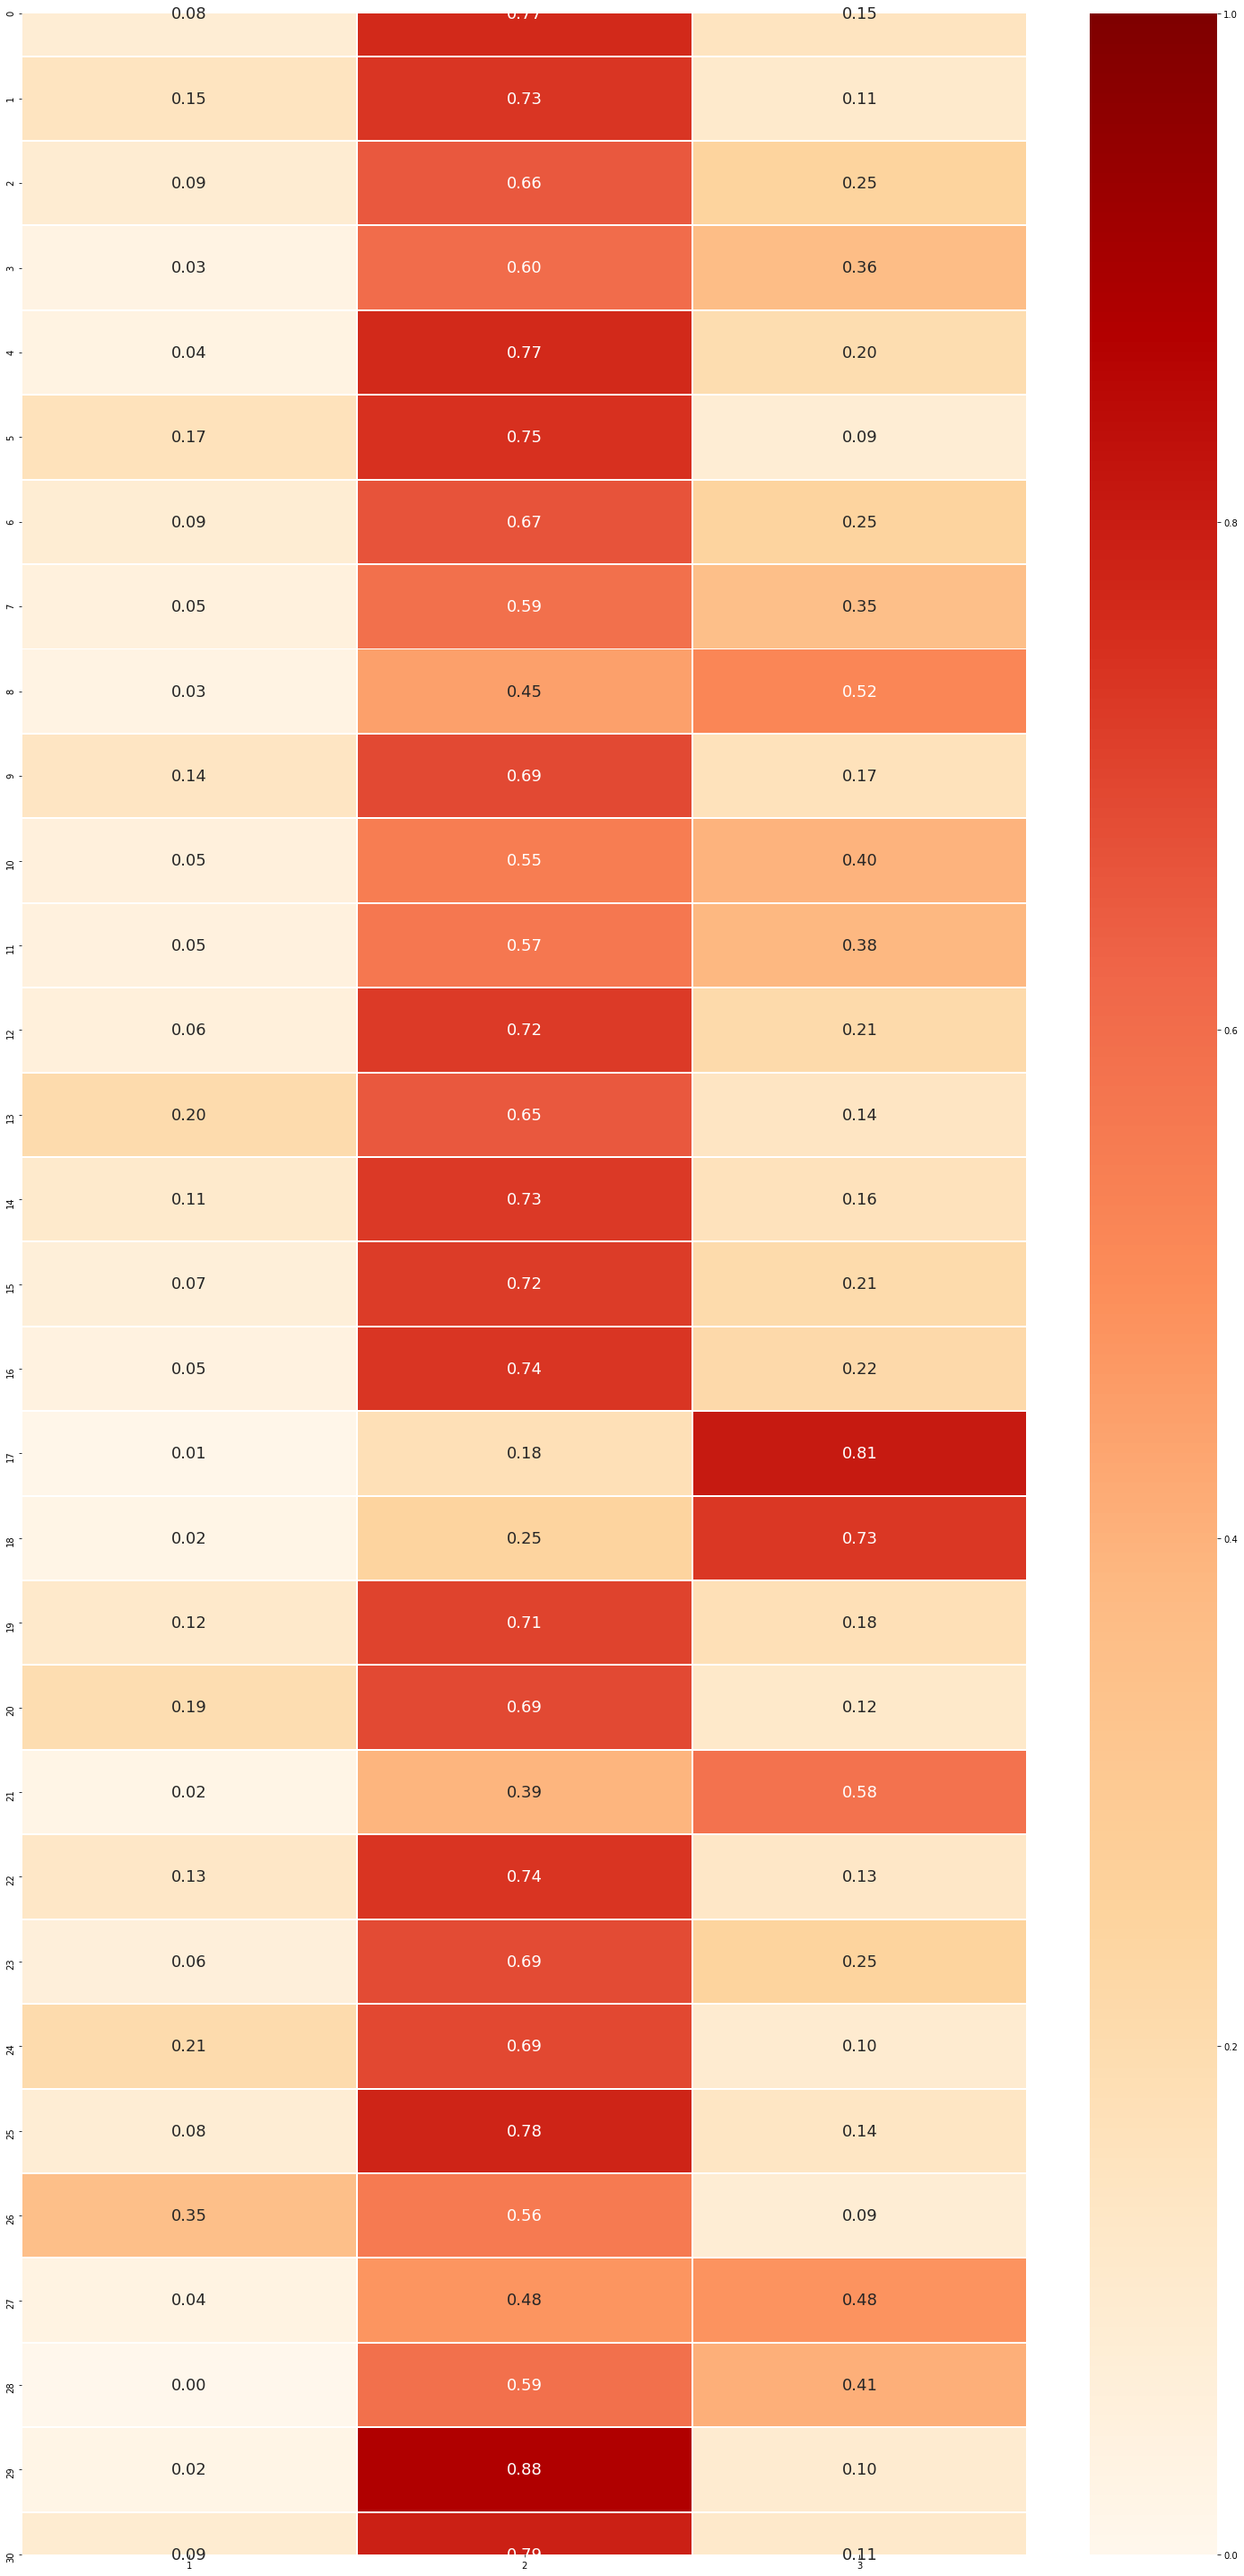

In [26]:
arr = np.zeros((31, 3))

for i in total_list:
    x = i[0]
    y = i[1]
    grade_one = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 1))
    grade_two = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 2))
    grade_three = np.sum((data['geo_level_1_id'] == x) & (data['damage_grade'] == 3))
    
    arr[x][0] = grade_one/y
    arr[x][1] = grade_two/y
    arr[x][2] = grade_three/y


df = pd.DataFrame(arr, columns=['1', '2', '3'])

f, axes = plt.subplots(1, 1, figsize=(20, 40))
sb.heatmap(df, vmin = 0, vmax = 1, linewidths = 1, annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "OrRd")
f.tight_layout()

From the heatmap, we can further observe that the percentage of damage_grade = 3 at most locations are relatively low(<=40%) compared to damage_grade = 2. However at index 17 and 18, the percentage of damage_grade = 3 are extremely high (>70%). This may suggest that theses 2 locations are close to the epicenter.

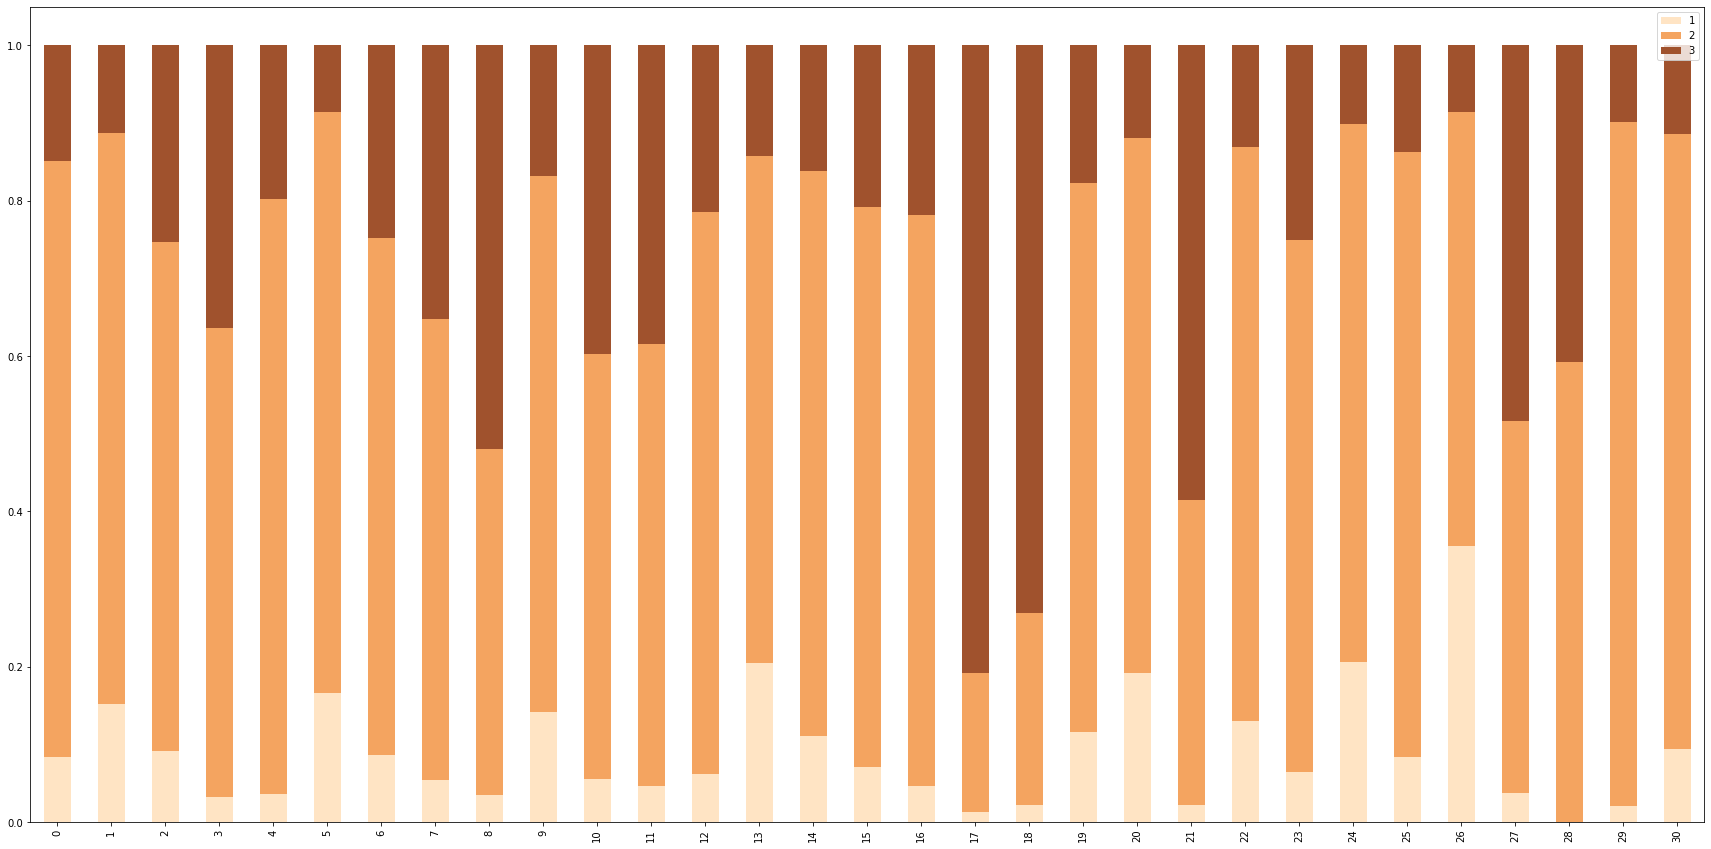

In [27]:
df.plot(kind='bar', stacked=True, color = ['bisque', 'sandybrown', 'sienna'], figsize=(30,15))

The same obervation on the abnormal distribution at index 17,18 (a lot of damage grade 3) and 26 (a lot of damage grade 1) can be observed from the figure above. From these visualizations, we believe that the values of geo_level_1_id may have quite a large impact on the level of damage grade

<h4>has_superstructure_xxx vs Damage Grade</h4>

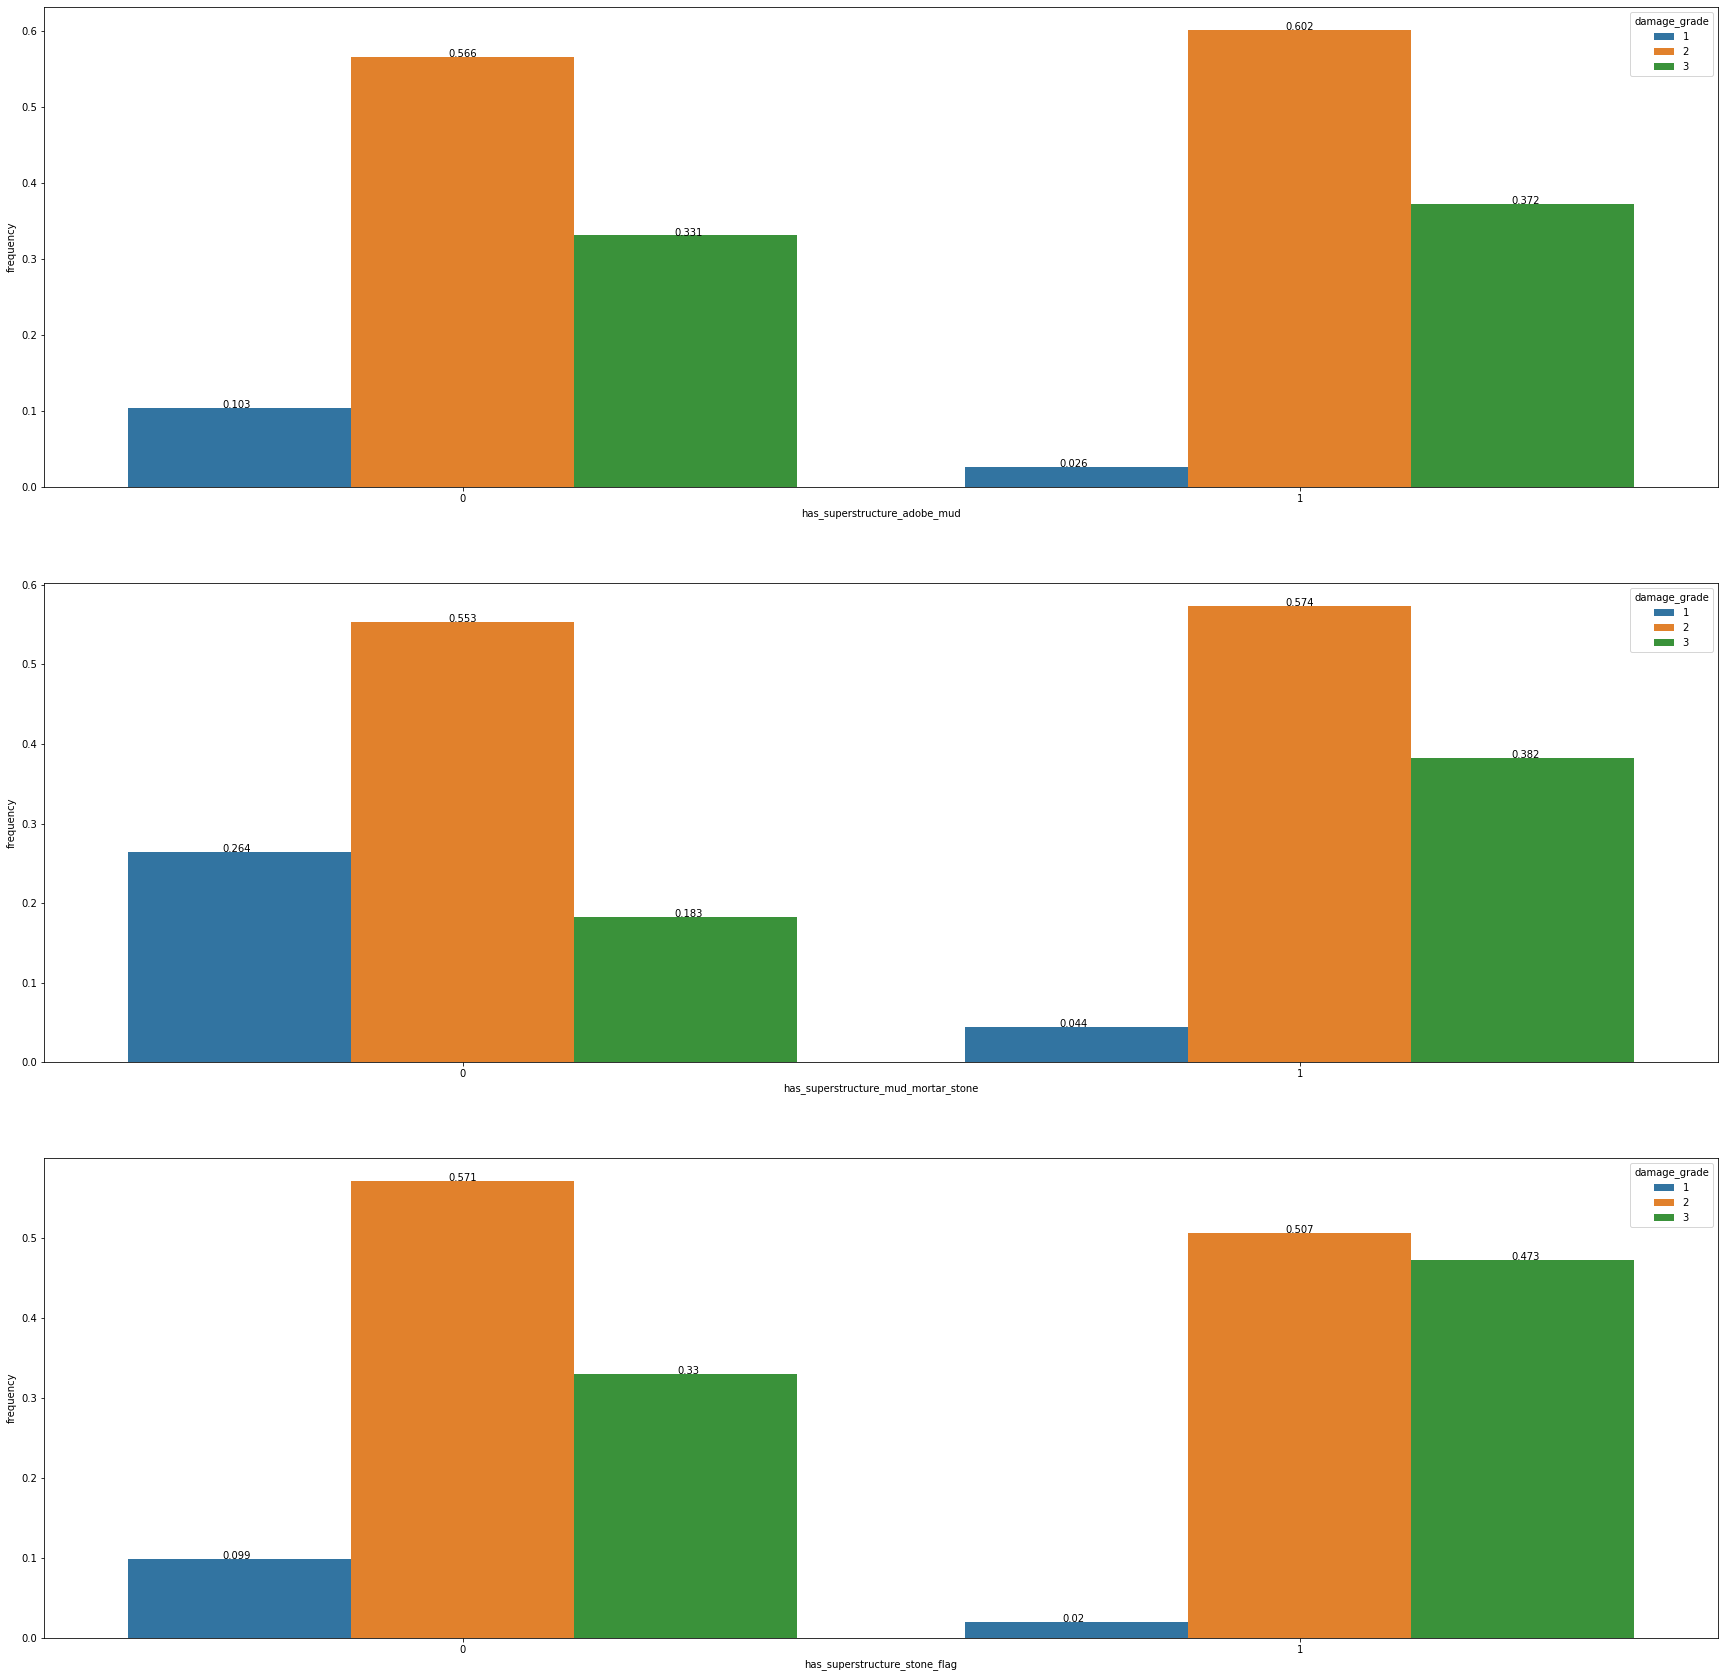

In [28]:
f,axes = plt.subplots(3,1,figsize=(30,30))
for i in range(3):
    j=i
    plotfreq(data, has[j], axes[i])

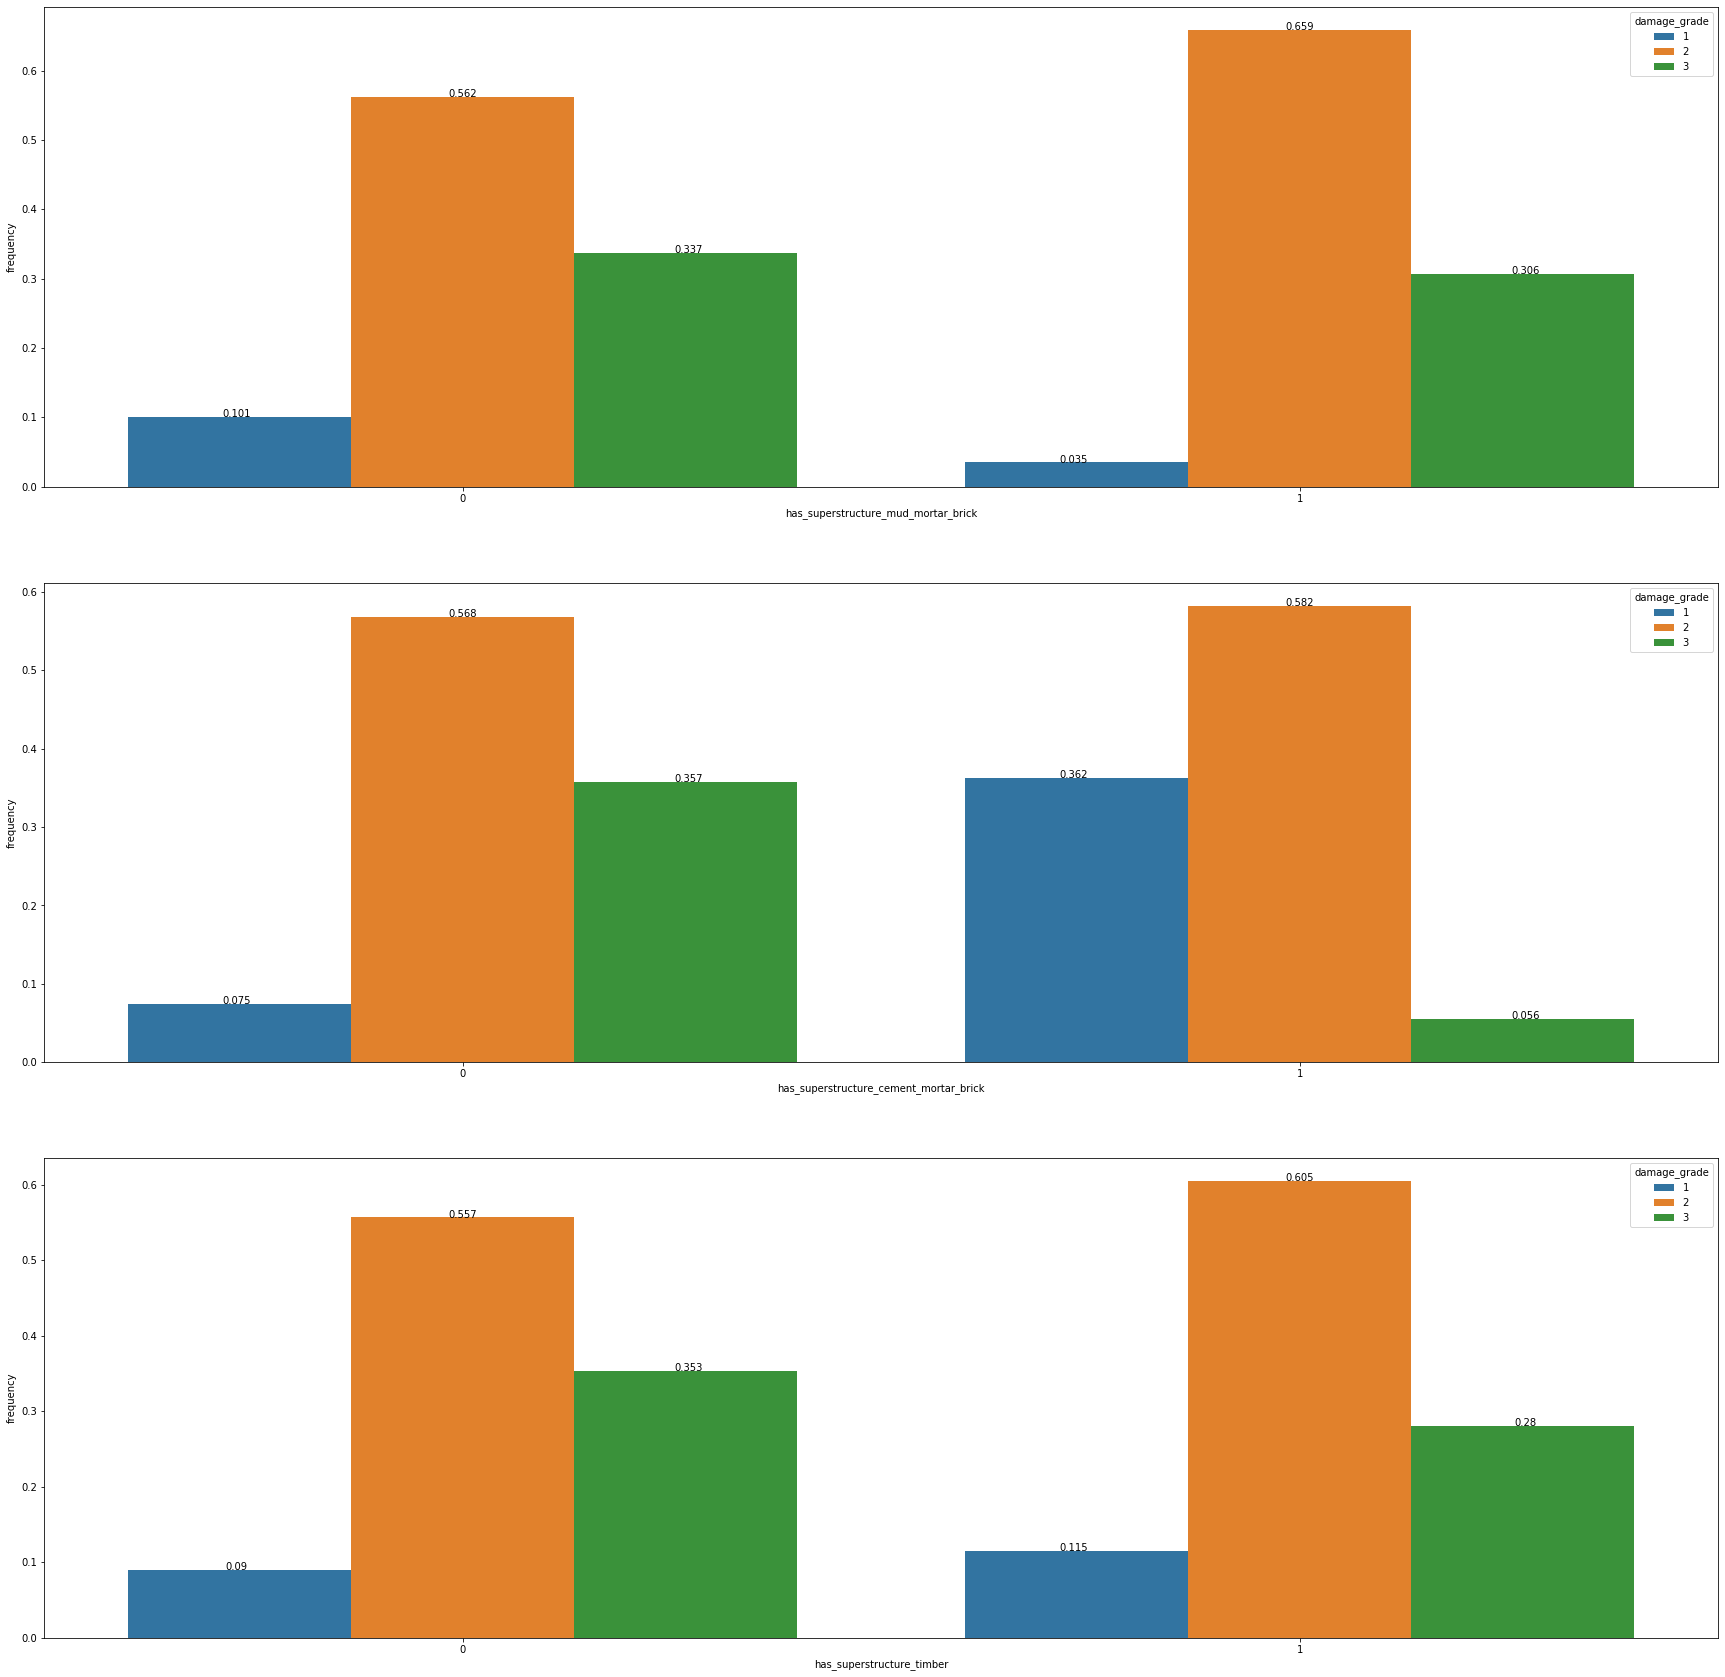

In [29]:
f,axes = plt.subplots(3,1,figsize=(30,30))
for i in range(3):
    j=i+4
    plotfreq(data, has[j], axes[i])

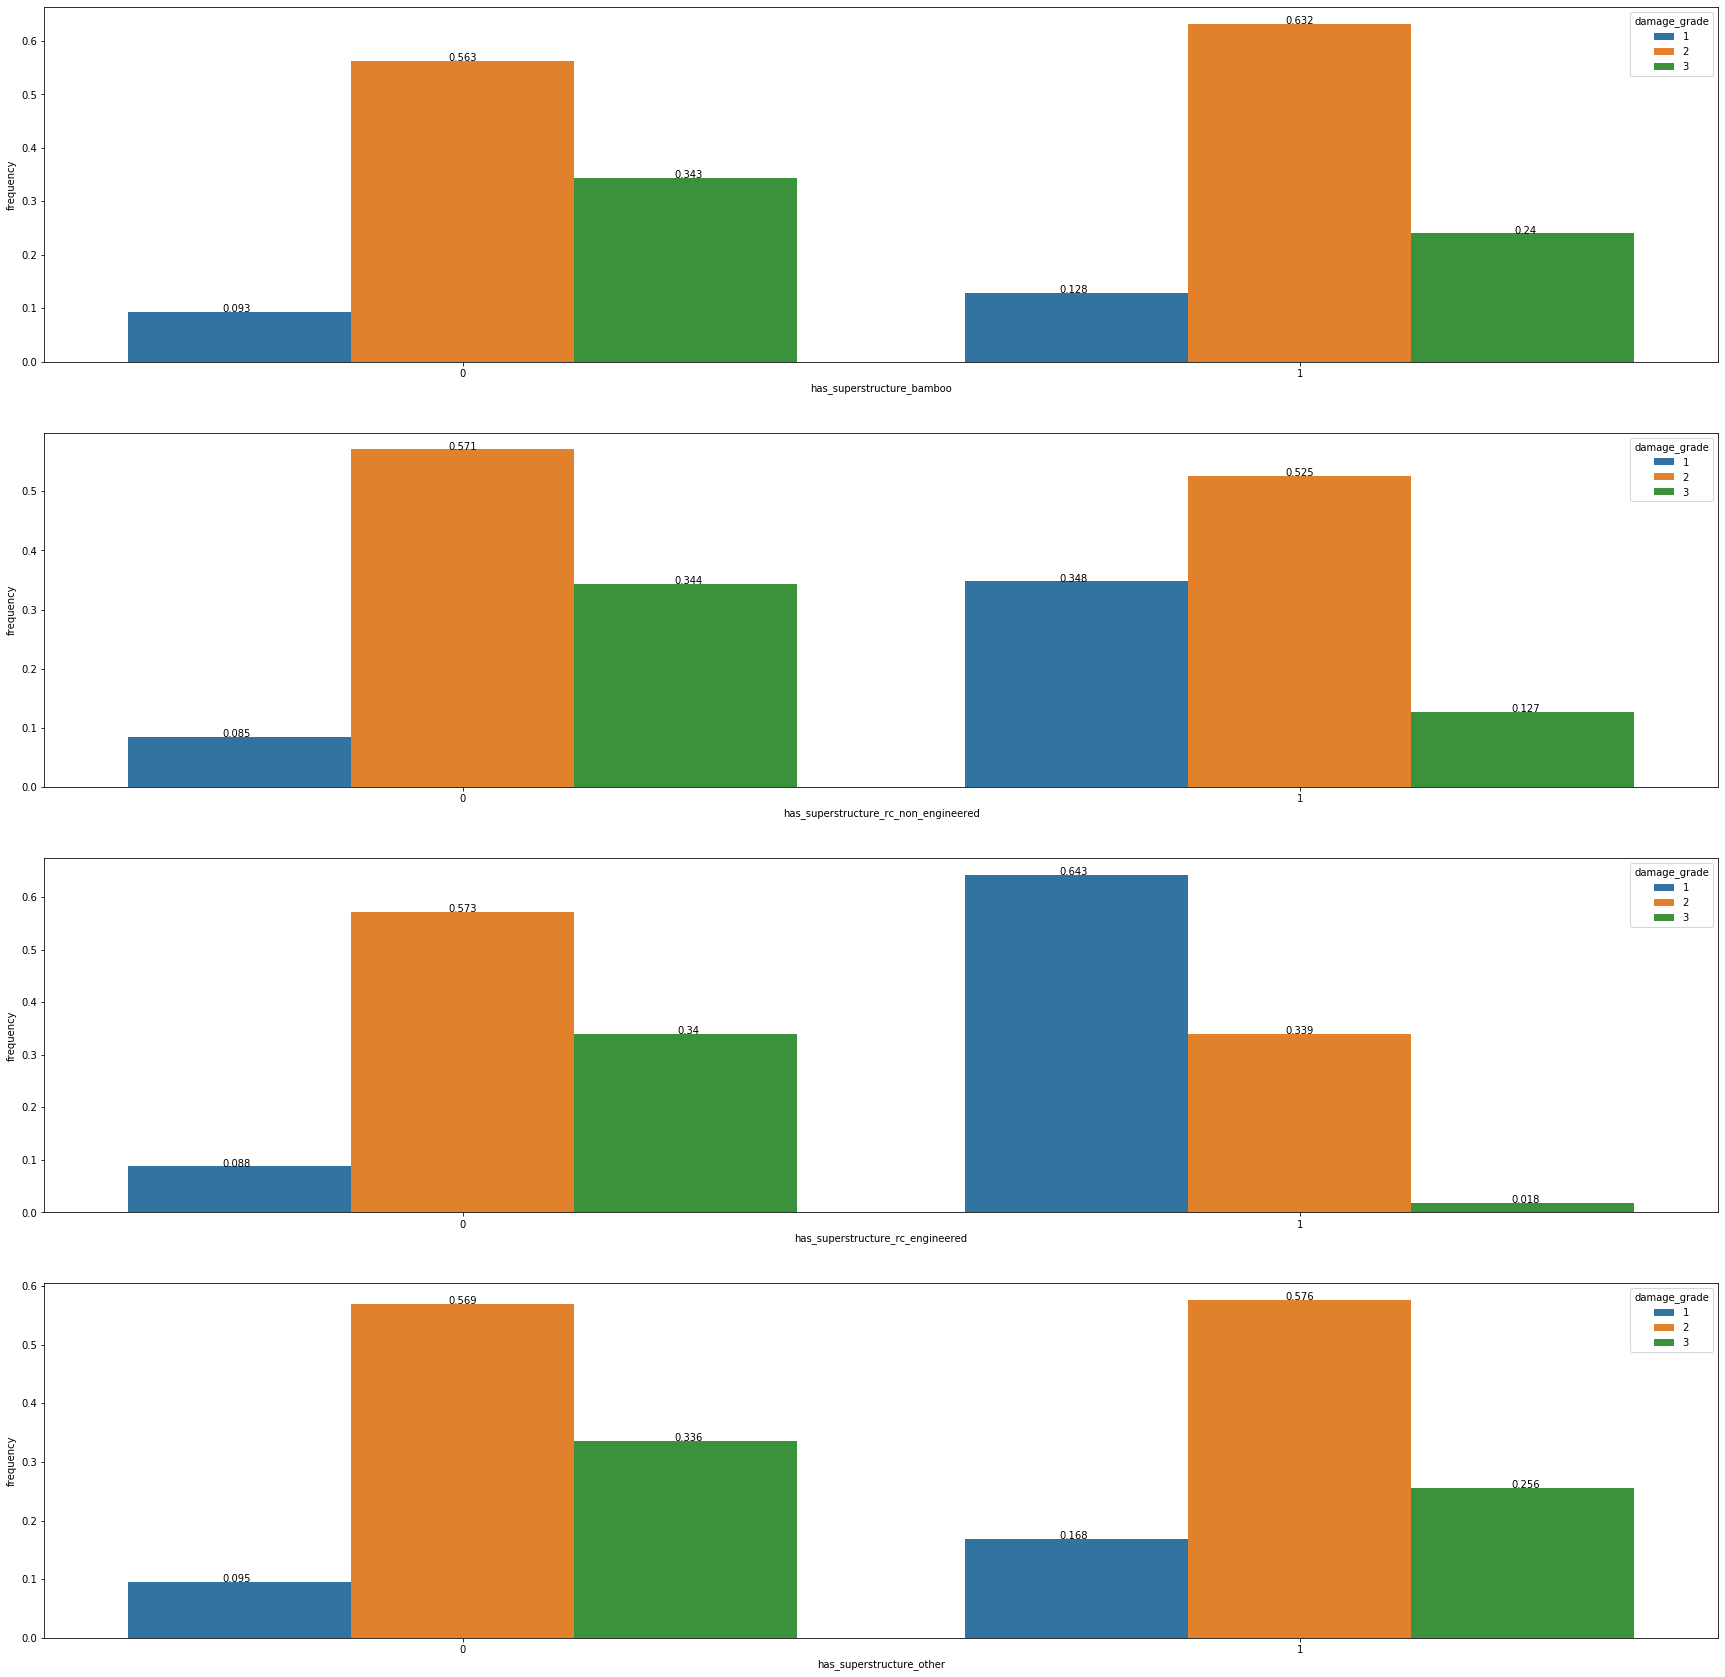

In [30]:

f,axes = plt.subplots(4,1,figsize=(30,30))
for i in range(4):
    j=i+7
    plotfreq(data, has[j], axes[i])

From the degree of changes to the distribution of damage grade when the value of the has_superstructure_xxx changes from 0 to 1, we observed that:

<p>These features do not seem to cause a significant difference in damage grade:<br>
    has_superstructure_adobe_mud<br>
    has_superstructure_mud_mortar_brick<br>
    has_superstructure_stone_flag<br>
    has_superstructure_timber<br>
    has_superstructure_bamboo</p>
    has_superstructure_other</p>
    
<p>These features seem to make a difference in damage grade:<br>
    has_superstructure_mud_mortar_stone<br>
    has_superstructure_cement_mortar_brick<br>
    has_superstructure_rc_non_engineered<br>
    has_superstructure_rc_engineered</p>

<h4>has_secondary_use_xxx vs Damage Grade</h4>

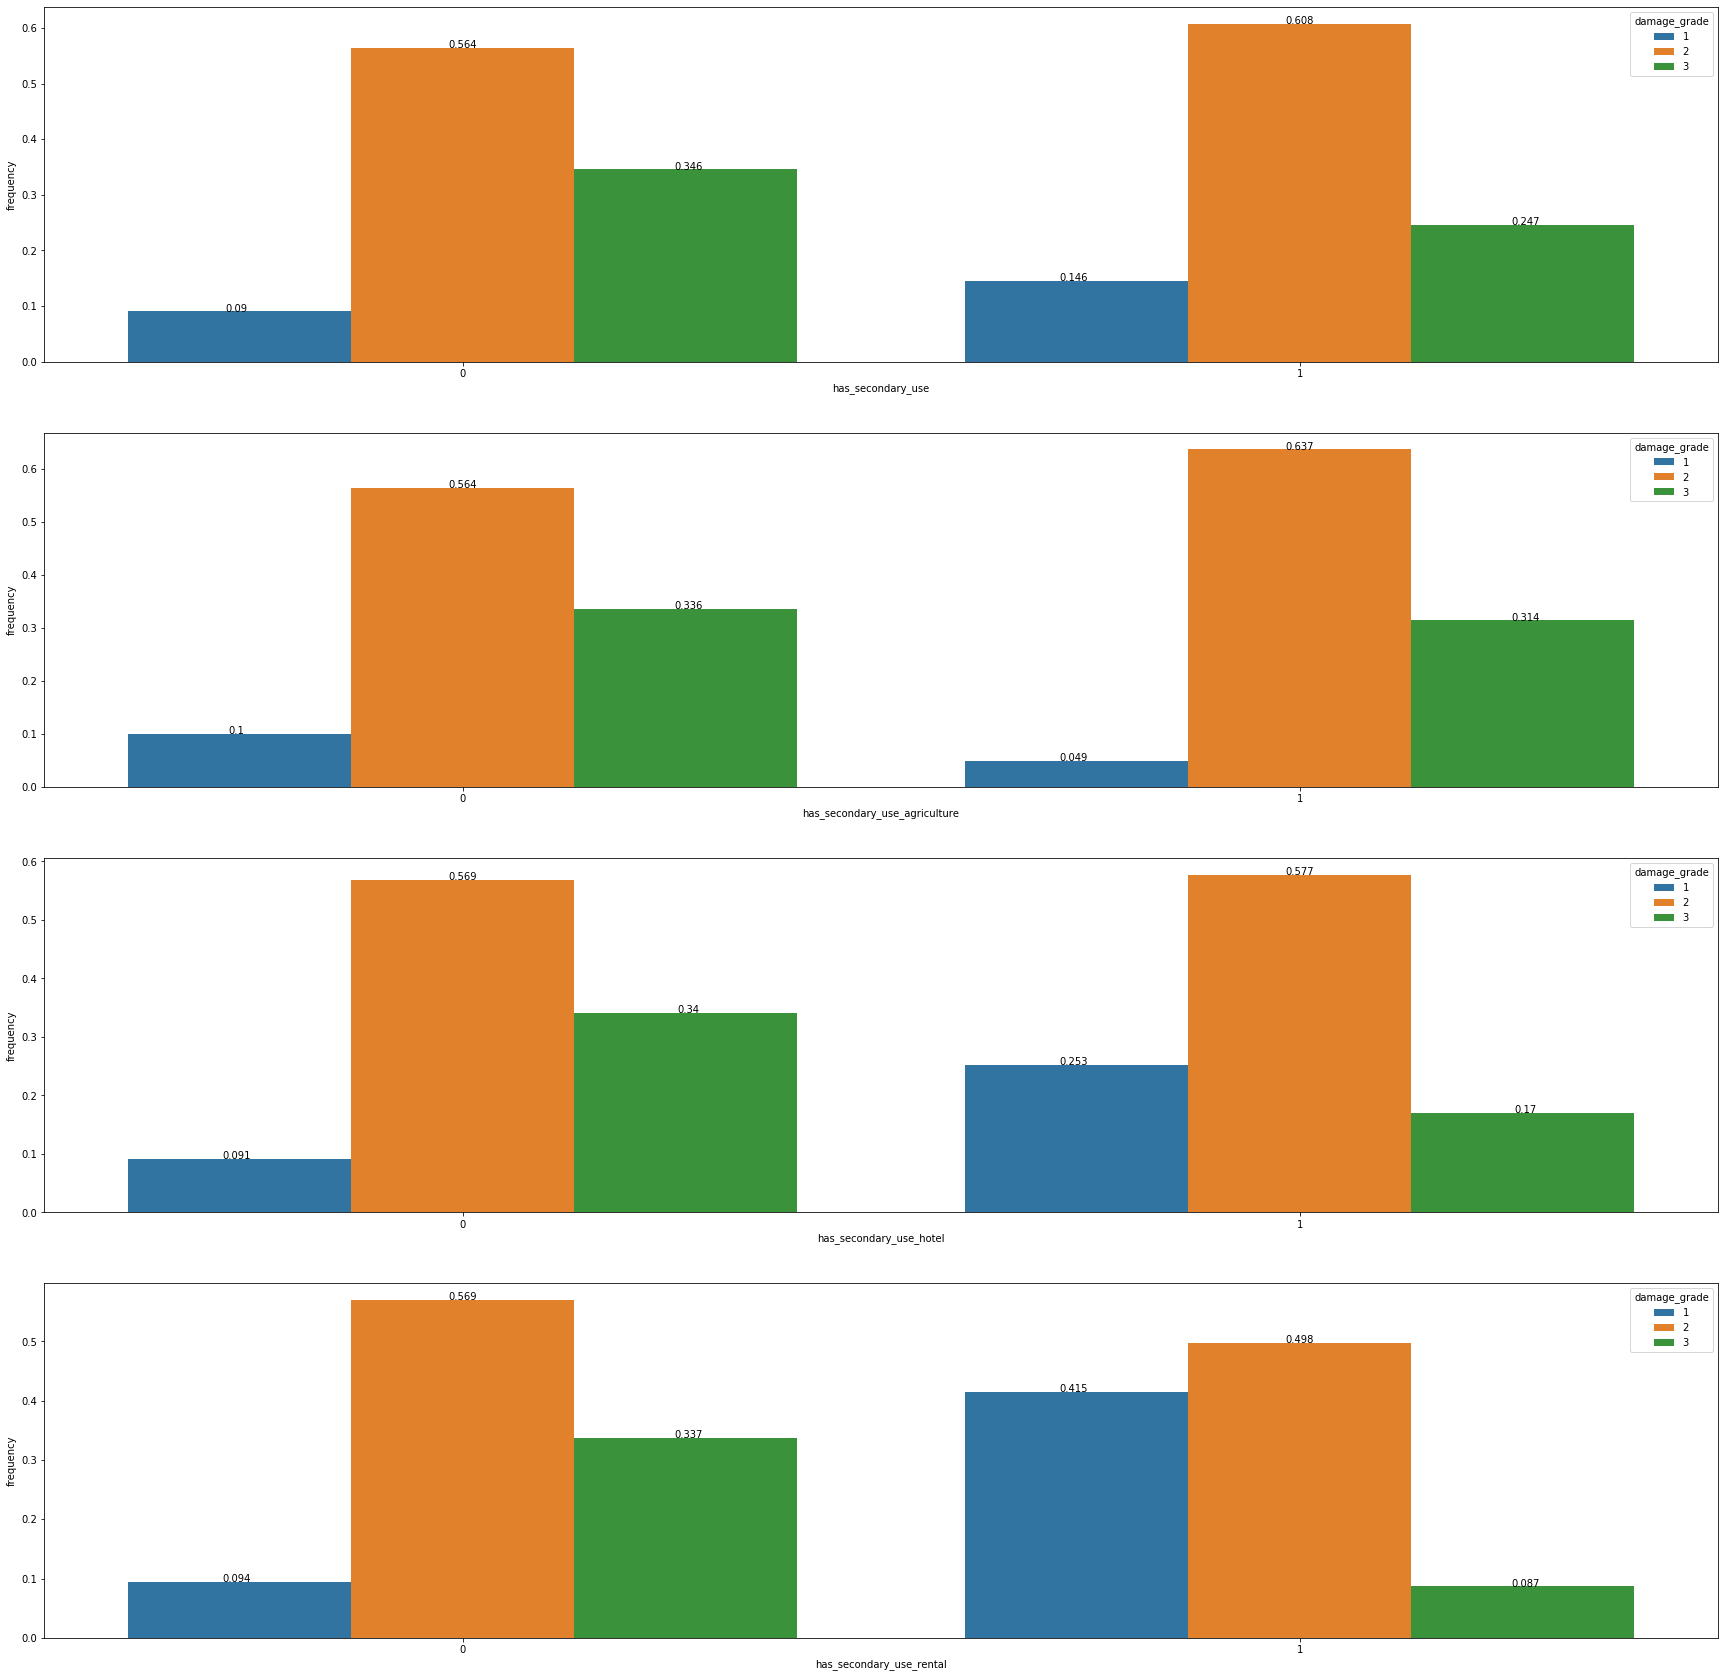

In [31]:
f,axes = plt.subplots(4,1,figsize=(30,30))
for i in range(4):
    j=i+11
    plotfreq(data, has[j], axes[i])

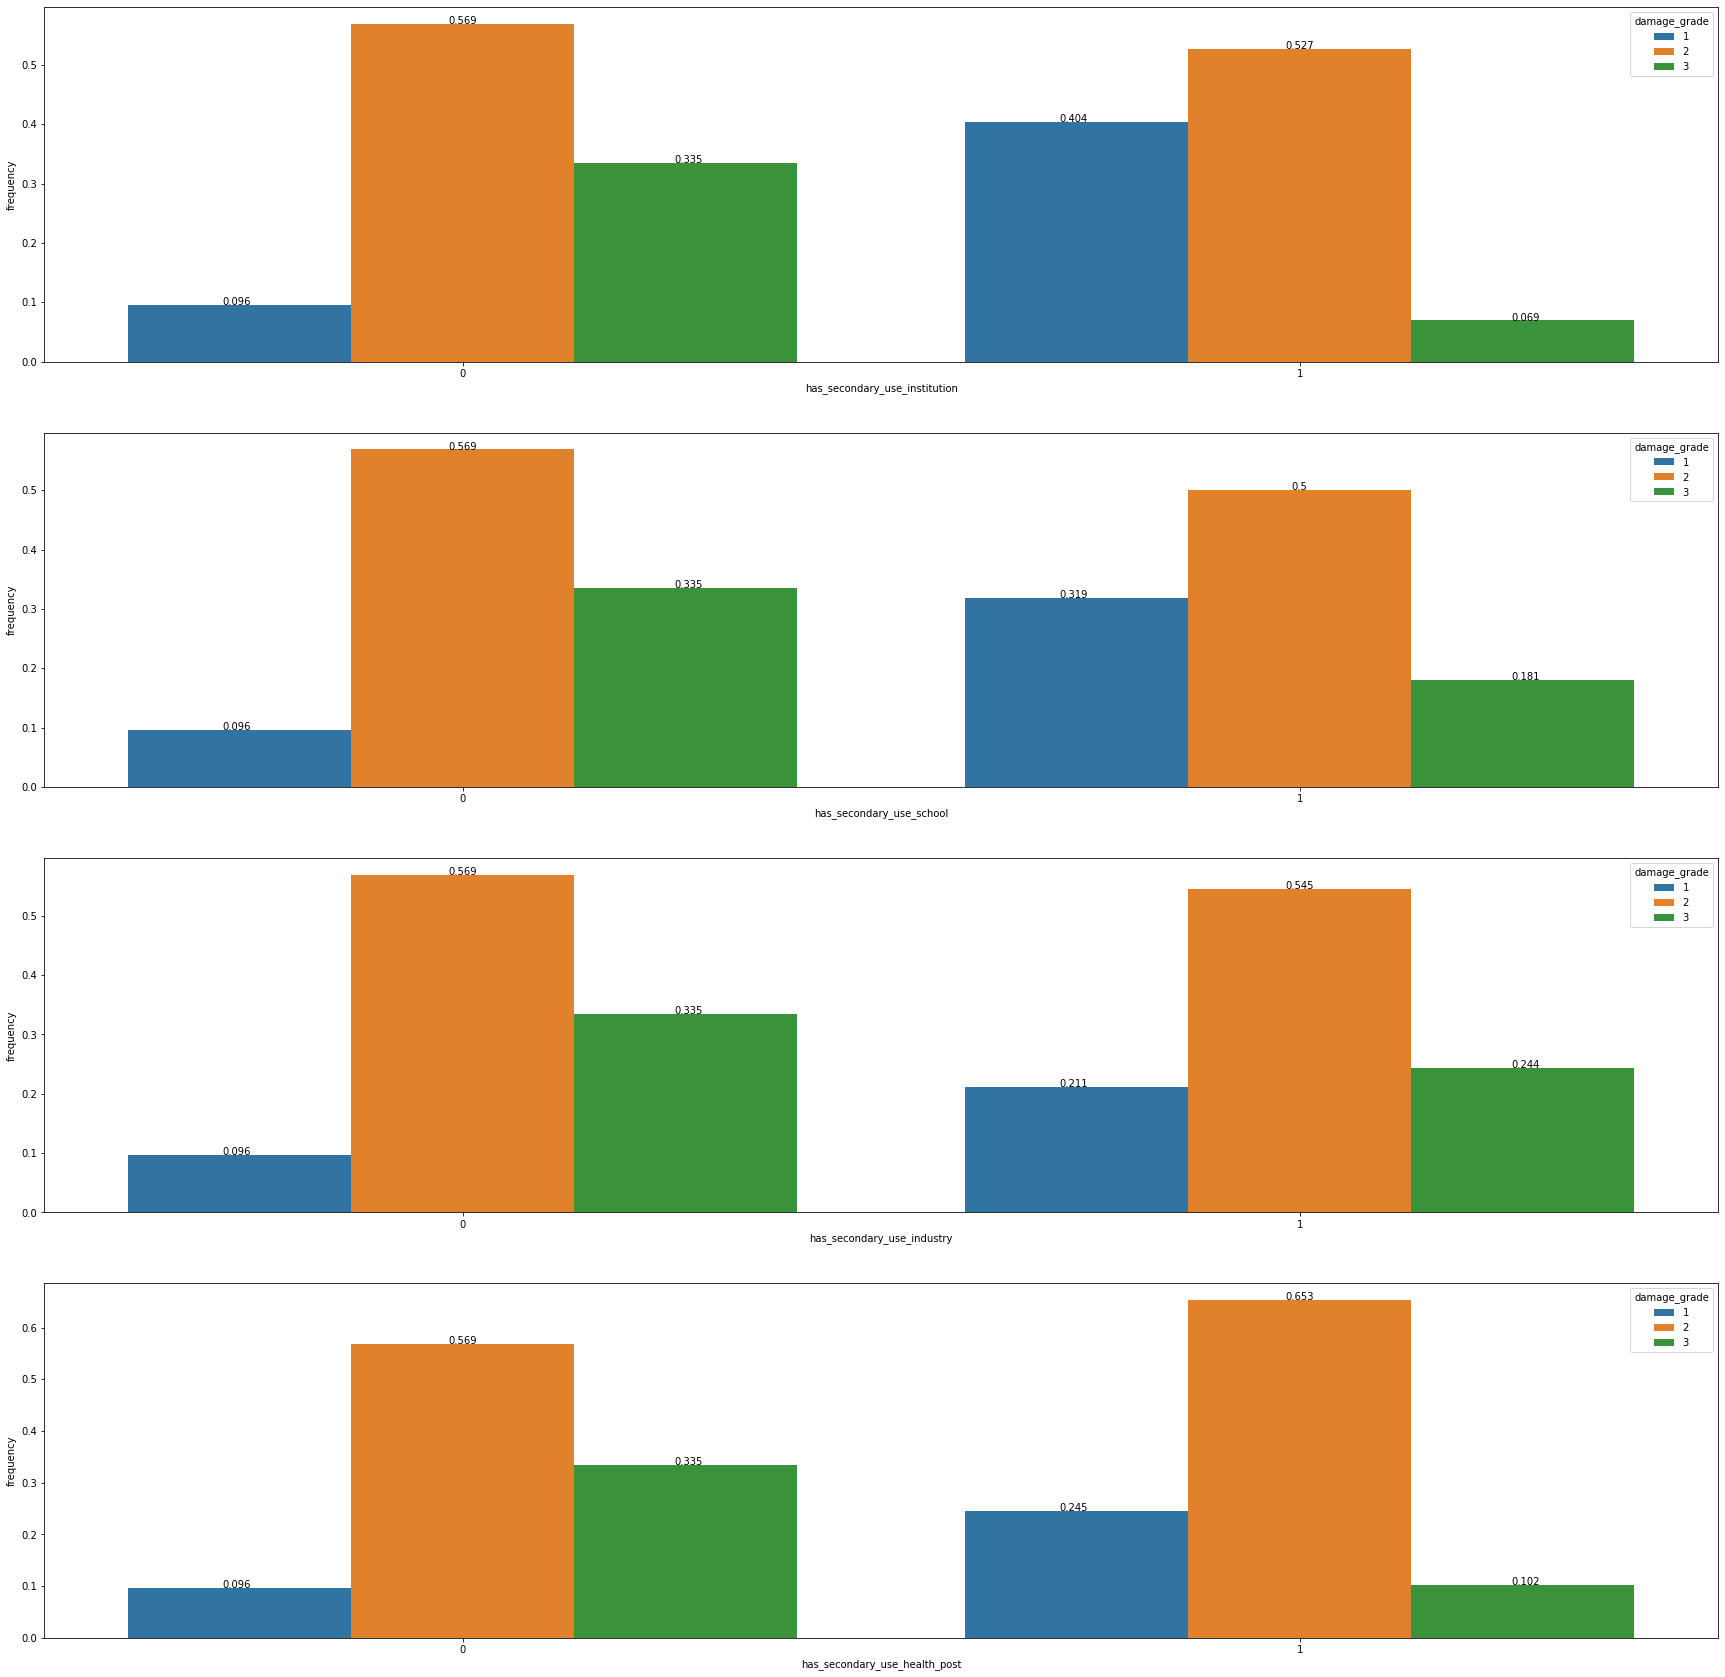

In [32]:
f,axes = plt.subplots(4,1,figsize=(30,30))
for i in range(4):
    j=i+15
    plotfreq(data, has[j], axes[i])

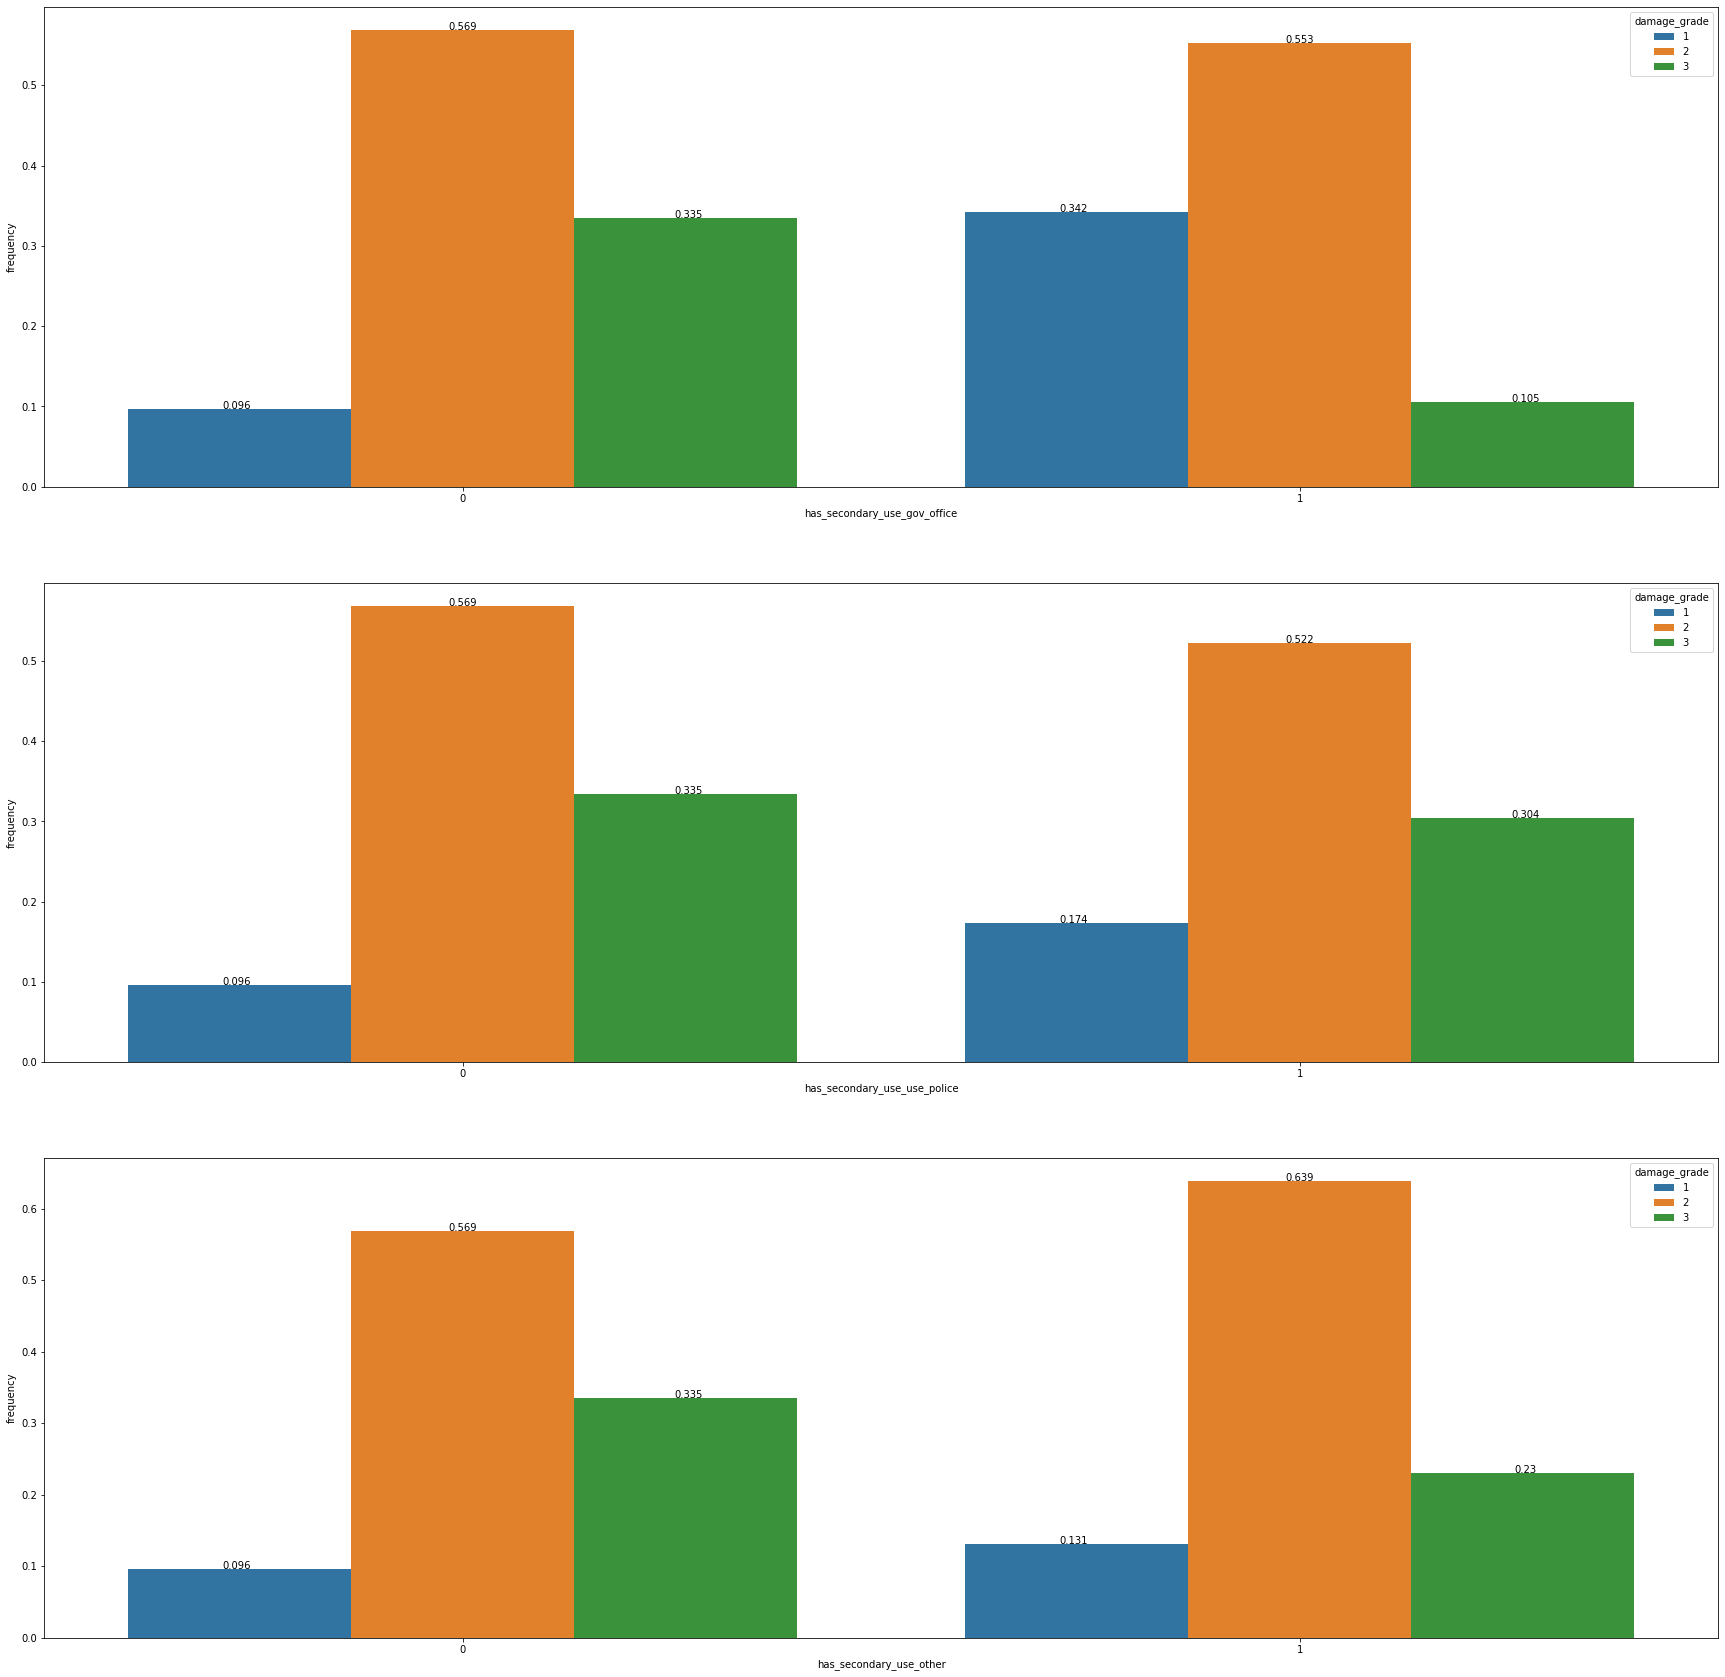

In [33]:
f,axes = plt.subplots(3,1,figsize=(30,30))
for i in range(3):
    j=i+19
    plotfreq(data, has[j], axes[i])

<p>Generally, the buildings with secondary use suffer less damage. Notably, rental, hotel, institution, school, office, and health posts either have much more damage grade 1, or fewer damage grade 3.</p>

<h4>Other categorical predictors vs Damage Grade</h4>

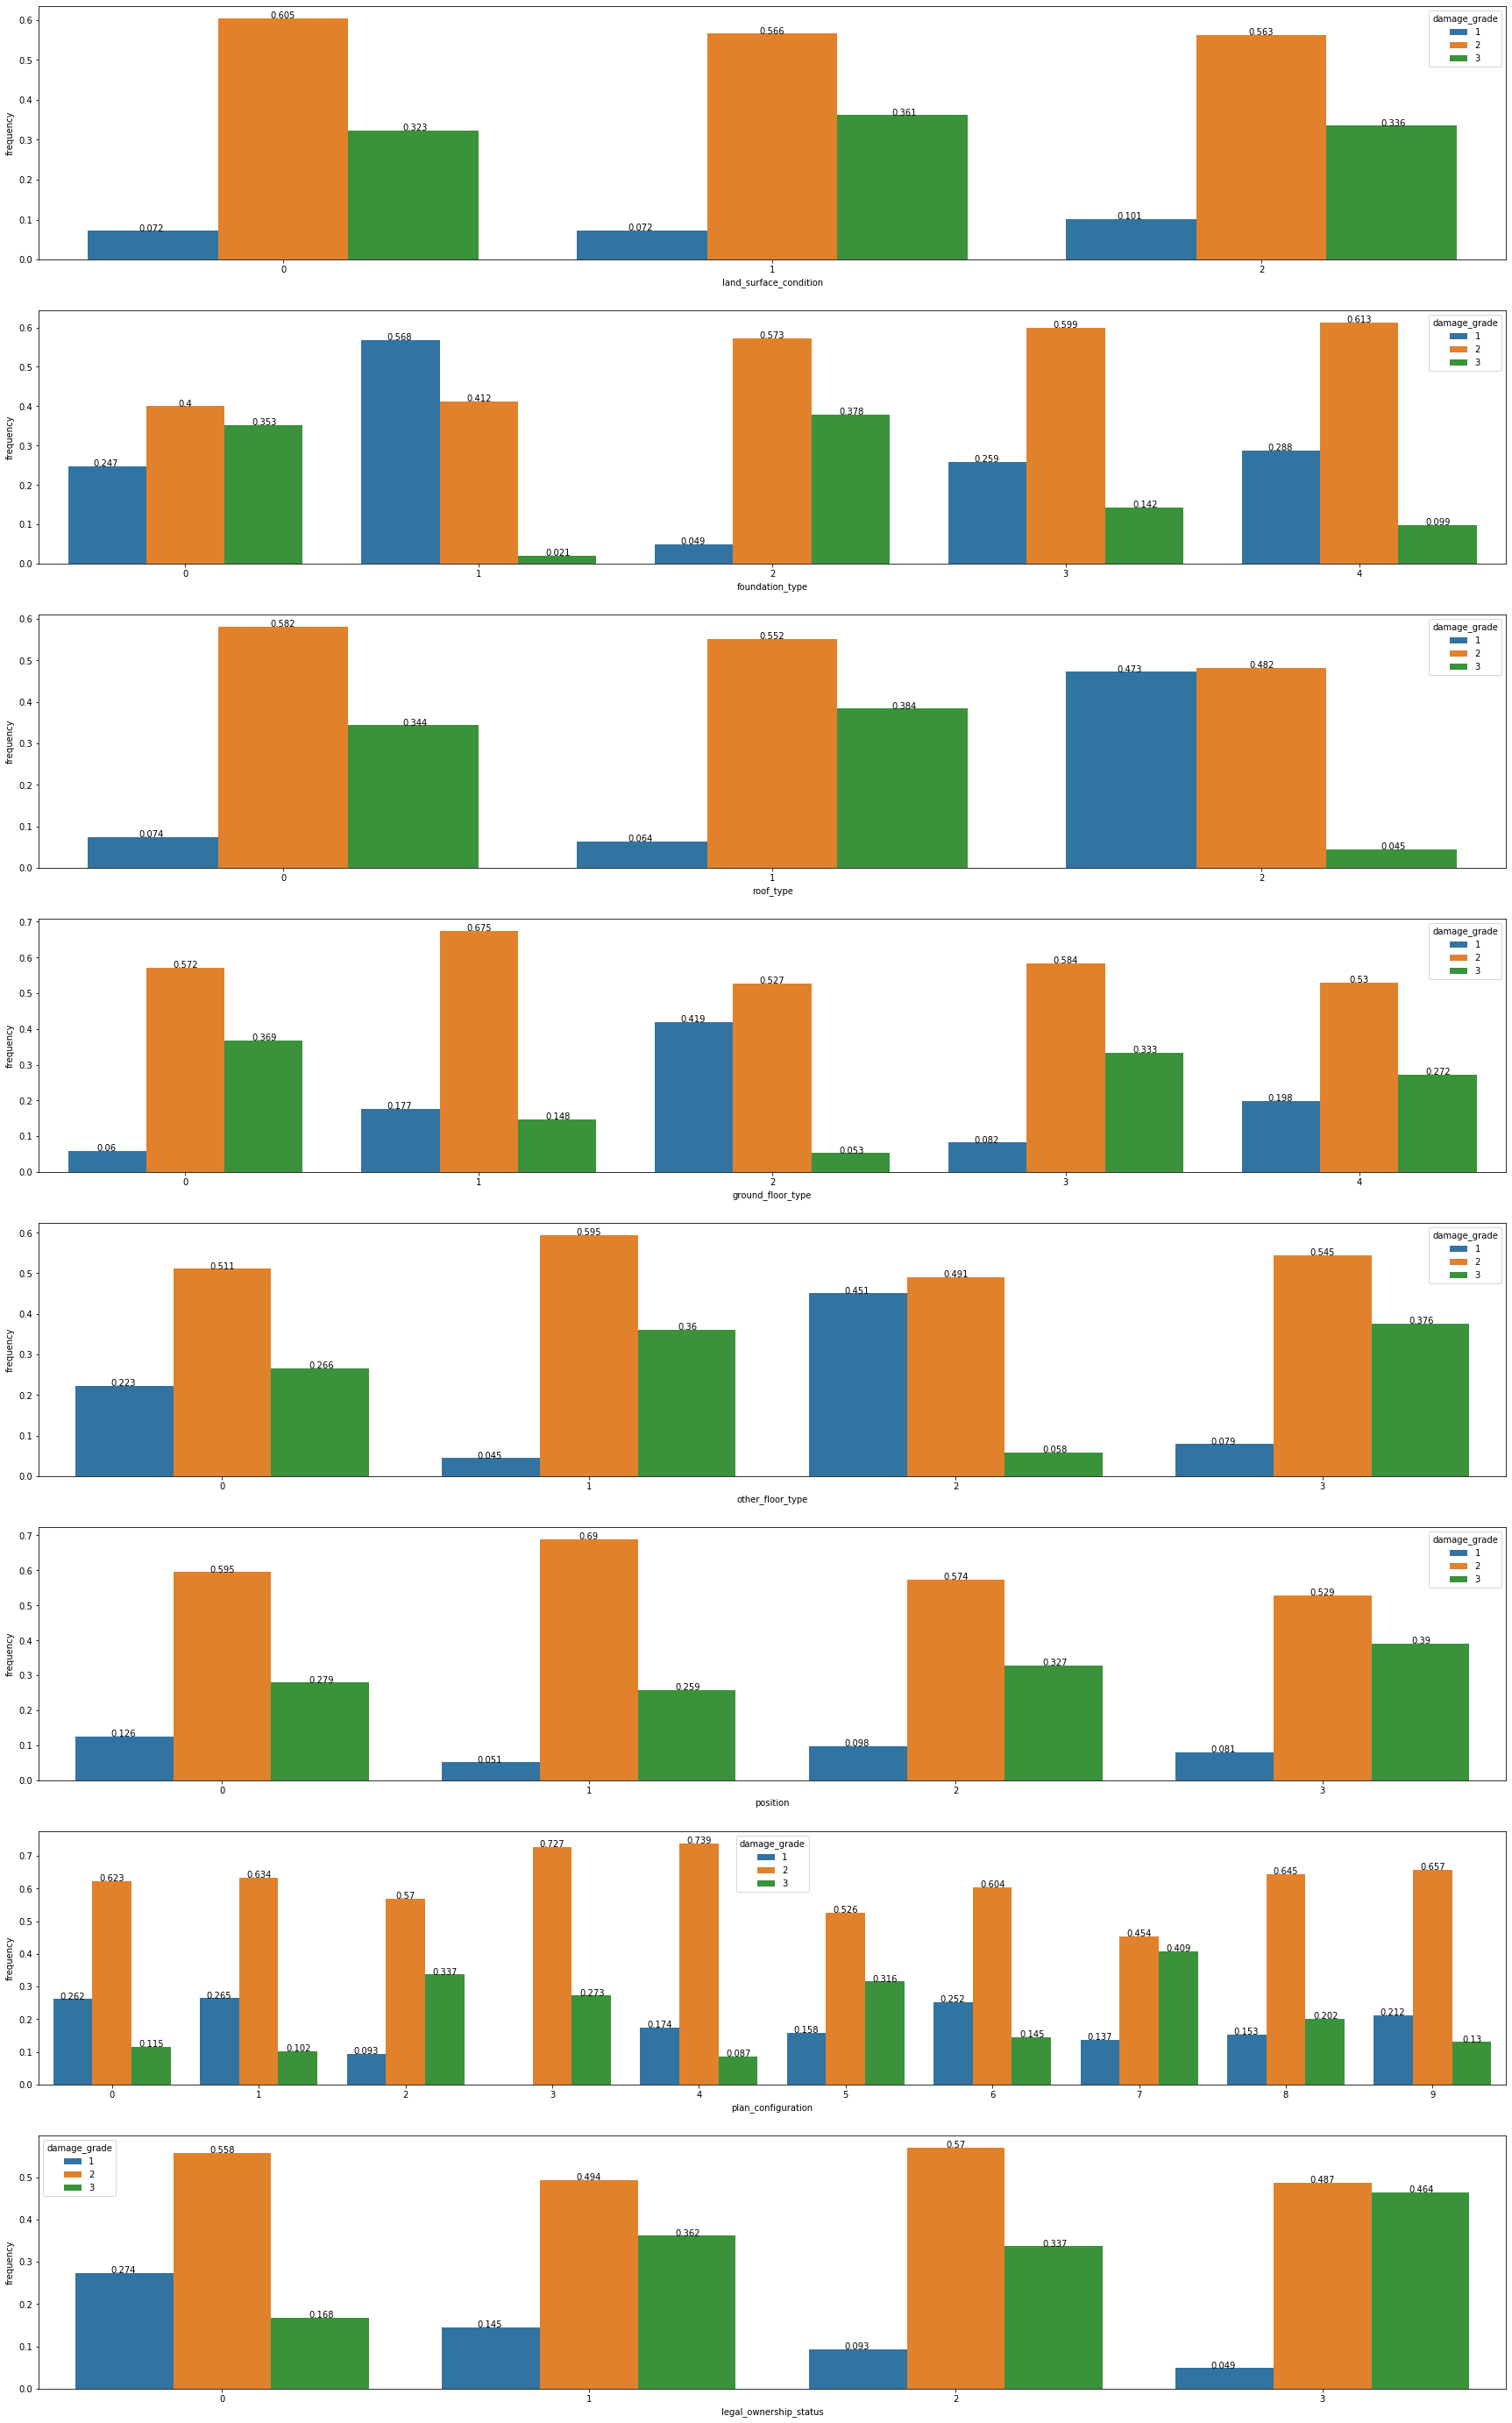

In [34]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
f, axes = plt.subplots(8,1,figsize=(30,50))
for i in range(8):
    temp = pd.DataFrame(enc.fit_transform(data[cat_col[i]]),columns=[cat_col[i]])
    temp = pd.concat([temp, data['damage_grade']], axis=1)
    plotfreq(temp, cat_col[i], axes[i])

##### From the distributions, we found the following:

- land_surface_condition seemed to be not important in predicting damage grade.


- Foundation_type seemed to be important in predicting damage grade. Type 1 resulted in the least damage and type 2 resulted in the most damage.


- Roof_type type seemed to be important in predicting damage grade. Type 2 resulted in least damage and type 1 resulted in the most damage.


- Ground_floor_type seemed to be important in predicting damage grade. Type 2 resulted in least damage and type 0 resulted in most damage.


- Other_floor_type seemed to be important in predicting damage grade. Type 2 resulted in least damage and type 1 and 3 resulted in most damage.


- Position seemed to be not important in predicting damage grade.


- Plan_configuration seemed to be important in predicting damage grade. Type 0 resulted in least damage and type 7 resulted in most damage.


- Legal_ownership_status seemed to be important in predicting damage grade. Type 0 resulted in least damage and type 3 resulted in most damage. 

For the above categorical variables, we changed the name of the classes from letters such as n,q,x (for roof_type) to 0,1,2 in alphabetical order. We did it because it allowed us to easily show the exact of distribution of each class in percentage and include the percentages in the plots. By including the percentages, we can observe the changes to the distributions in more detail.

##### Conclusion on all categorical predictors
<p>It seemed that the "has_secondary_use_xxx" and "has_superstructure_xxx" categorical variables might be more useful in predicting the damage grade due to their more varying distribution of damage grades between the classes of the predictor. 
    
<p>Due to similar distributions, we can merge these classes together:<br>
    <ul>
    <li>foundation_type 3, 4 </li>
    <li>roof_type 0,1</li>
    <li>ground_floor_type 0,3</li>
    <li>other_floor_type 1,3</li>
    <li>plan_configuration 0,1,6,9</li>
    </ul>

# Bivariate Analysis (Predictor vs Predictor)
[Back to top](#Contents)

In [35]:
has_mat = has[0:11]
has_sec = has[11:]
other_cat = cat_col[:8]

#### Numeric-numeric

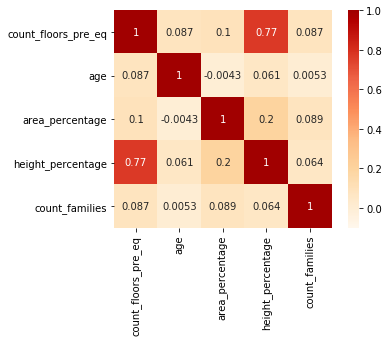

In [36]:
df = data[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage','count_families']]
corr = df.corr()
sb.heatmap(corr, vmin=-0.1, vmax=1, center=0.5, annot=True, cmap='OrRd', square=True)

#Plot got cut off on my jupyter client, just a workaround, ignore this:
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da

Strong positive correlation was found between height_percentage and count_floors_pre_eq, implying a strong linear relationship between them. Therefore, we could remove one of them before model training

#### categorical-categorical

In [37]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def plot_cat_confusion_matrix(data,cols,w,h,number_size):
    width = len(cols)
    matrix = np.zeros([width,width])
    for i in range(width):
        for j in range(width):
            matrix[i,j] = cramers_v(data[cols[i]],data[cols[j]])
    df_cm = pd.DataFrame(matrix, index=cols, columns=cols)
    f,axes = plt.subplots(1,1,figsize=(w,h))
    g = sb.heatmap(df_cm, ax = axes,  annot = True, cmap = 'OrRd', annot_kws = {"size":number_size})
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da



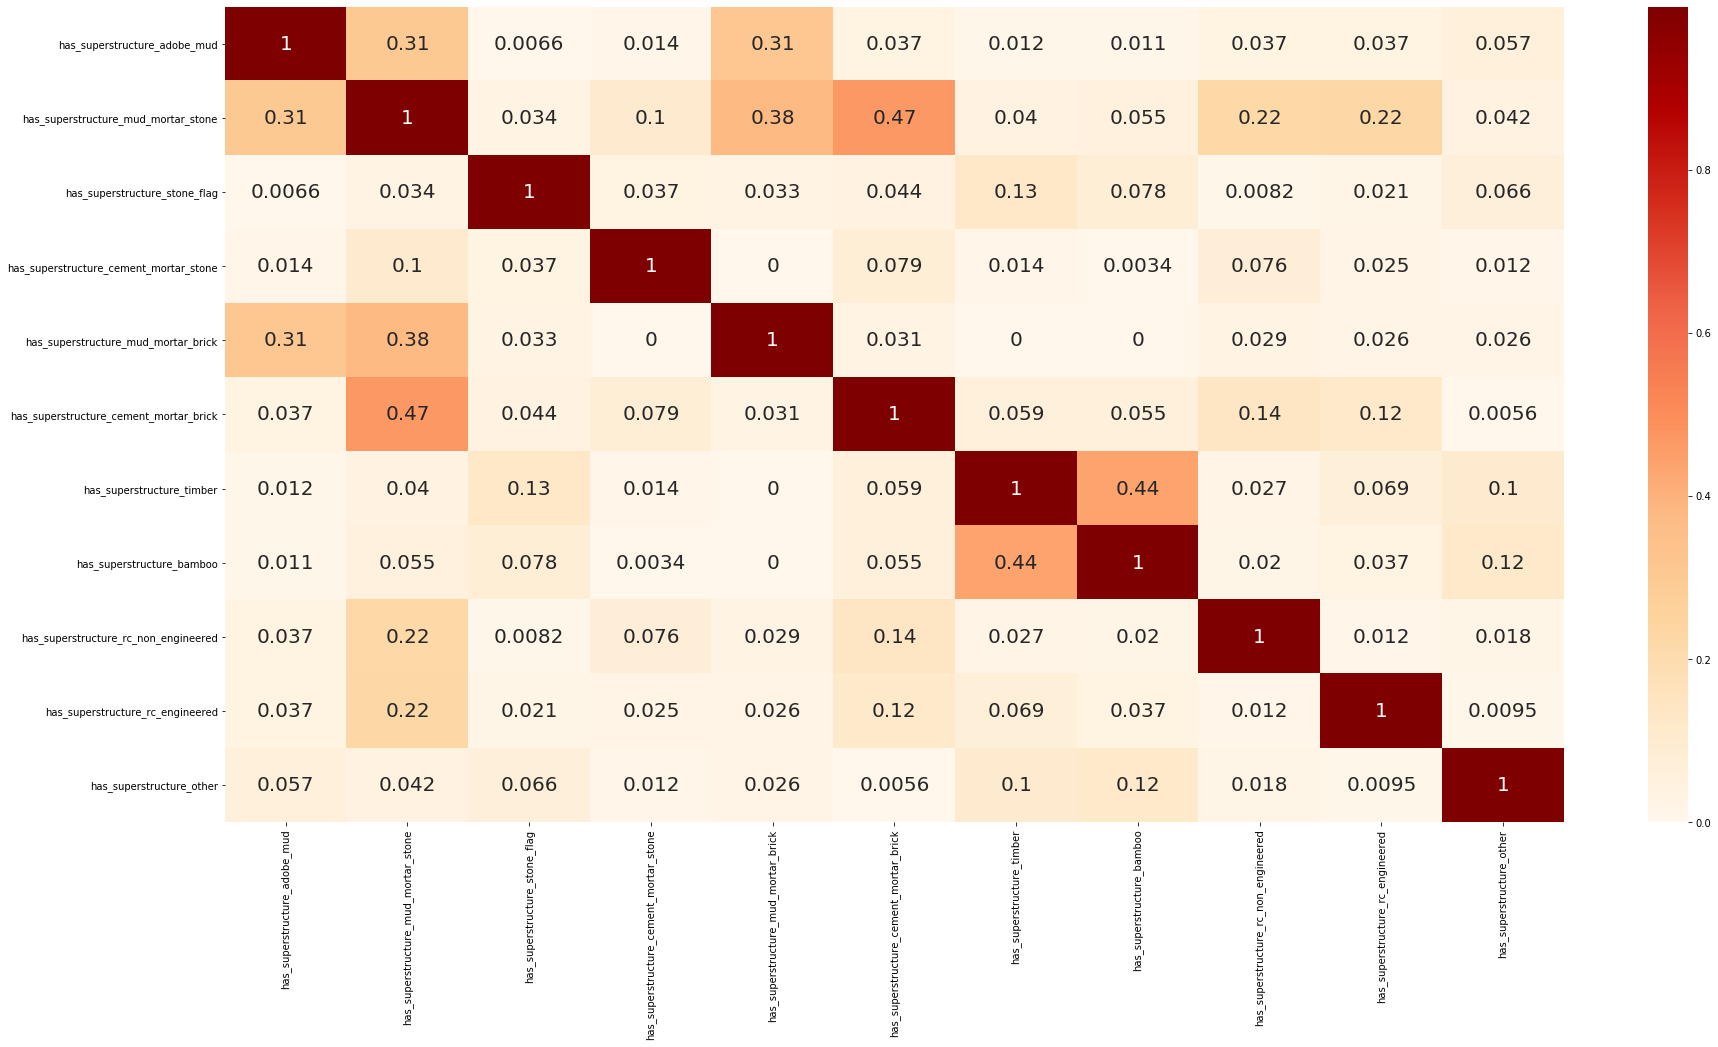

In [38]:
plot_cat_confusion_matrix(data,has_mat,30,15,20)

Most of the has_superstructure types have weak correlation with one another. Even the strongest correlation was only 0.47. Therefore, we will not remove any during data preprocessing

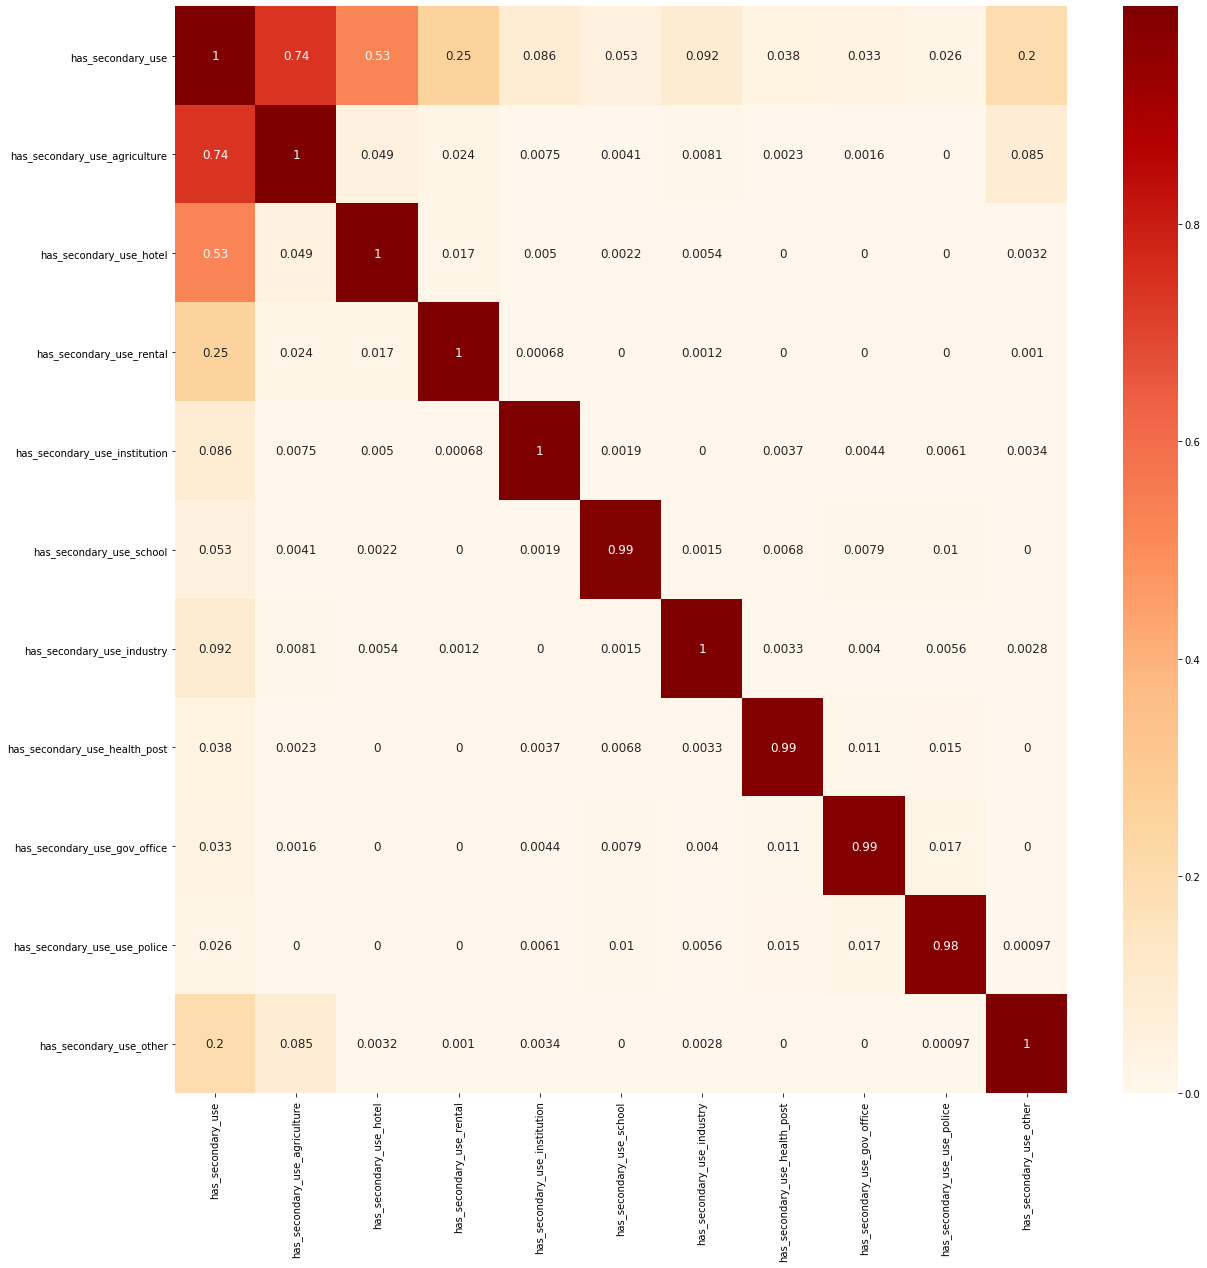

In [39]:
plot_cat_confusion_matrix(data,has_sec,20,20,12)

Has_secondary_use has strong correlation with has_secondary_use_agriculture. It also has 0.53 correlation with has_secondary_use_hotel. Therefore, we can remove Has_secondary_use before model training

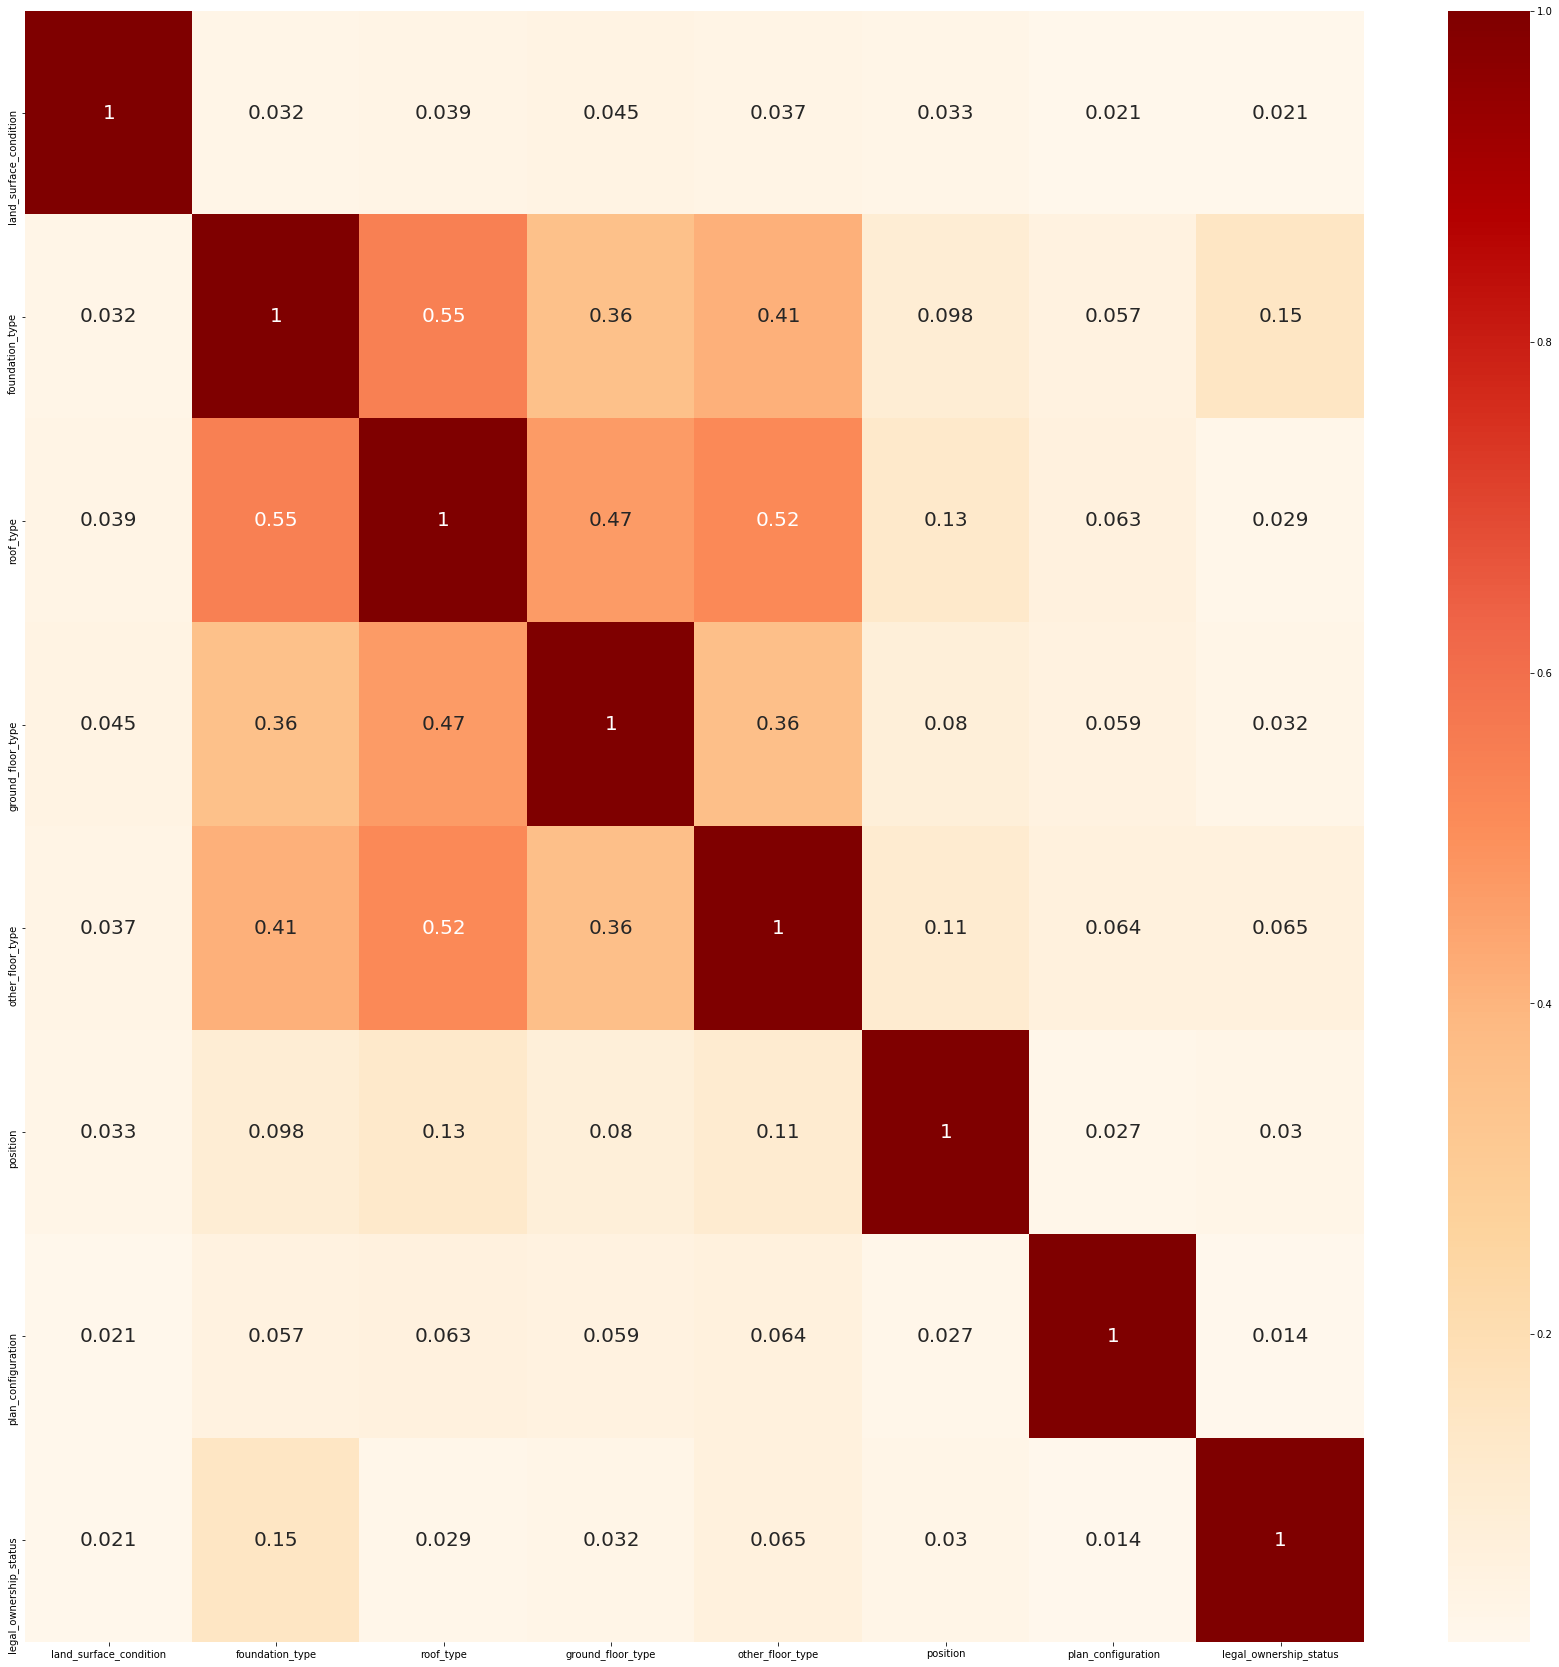

In [40]:
plot_cat_confusion_matrix(data,other_cat,30,30,20)

There was no strong correlation(>0.7) between the other categorical predictors. Still, roof_type seemed to have some degree of dependency with foundation_type, ground_floor_type and other_floor_type. 